In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import numpy as np
import cupy as cp
import copy
kgs.set_float32(True)
#kgs.TREE_EXPANSION =  0.
kgs.initialize_tree_globals()
kgs.convex_breakdown, kgs.just_over_one

local


([<POLYGON ((1.471e-18 0.58, 0.125 0.28, -0.125 0.28, 1.471e-18 0.58))>,
  <POLYGON ((0.063 0.28, 0.2 0.03, -0.2 0.03, -0.063 0.28, 0.063 0.28))>,
  <POLYGON ((0.1 0.03, 0.35 -0.22, -0.35 -0.22, -0.1 0.03, 0.1 0.03))>,
  <POLYGON ((0.075 -0.22, 0.075 -0.42, -0.075 -0.42, -0.075 -0.22, 0.075 -0.22))>],
 1.000001)

[0.]
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
    

<Axes: >

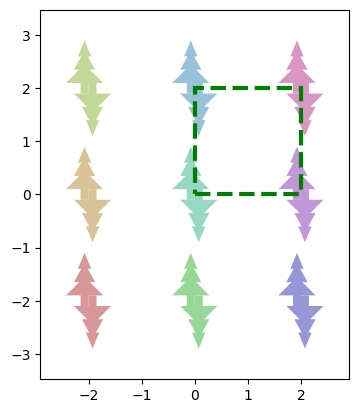

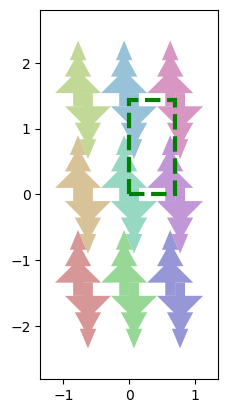

In [2]:
dimer = pack_dimer.create_dimer()
sol = kgs.SolutionCollectionLattice(xyt=dimer[None], h=cp.array([[2.,2.,np.pi/2]], dtype=kgs.dtype_cp), do_snap=False)
pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
print(pack_cost.CollisionCostOverlappingArea().compute_cost_ref(sol)[0].get())
print(pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0].get())
X=1/kgs.just_over_one
sol.xyt[0,:,:2]*=X
print(pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0].get())
sol.xyt[0,:,:2]/=X
sol.xyt[0,:,:2]/=X
print(pack_cost.CollisionCostOverlappingArea().compute_cost_allocate(sol)[0].get())
pack_dimer.snap_cell(sol, skip_assert=False)
pack_vis_sol.pack_vis_sol(sol, solution_idx=0)

In [3]:
import tqdm
importlib.reload(pack_dimer)
dimer = pack_dimer.create_dimer()
rot_tree_vals = cp.array(np.arange(0, np.pi/2*kgs.just_over_one, np.pi/20000), dtype=kgs.dtype_cp)
rot_cell_vals = cp.array(np.arange(np.pi/4, np.pi/2*kgs.just_over_one, np.pi/40), dtype=kgs.dtype_cp)
res_area = np.zeros((len(rot_tree_vals), len(rot_cell_vals)))
res_aspect_ratio = np.zeros((len(rot_tree_vals), len(rot_cell_vals)))
sol_base = kgs.SolutionCollectionLattice(xyt=dimer[None], h=cp.array([[3.,3.,np.pi/2]], dtype=kgs.dtype_cp), do_snap=False)
sol_base.xyt = cp.tile(sol_base.xyt[0], (len(rot_tree_vals),1,1))
sol_base.h = cp.tile(sol_base.h[0], (len(rot_tree_vals),1))
sol_base.rotate(rot_tree_vals)
sol_base.check_constraints()
for j, rot_cell in enumerate(tqdm.tqdm(rot_cell_vals)):
    sol = copy.deepcopy(sol_base)
    sol.h[:,2] = rot_cell        
    pack_dimer.snap_cell(sol, skip_assert=True)
    res_area[:,j] = pack_cost.AreaCost().compute_cost_allocate(sol)[0].get()
    res_aspect_ratio[:,j] = (sol.h[:,0]/(sol.h[:,1]*np.sin(sol.h[:,2]))).get()   
        


  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:01<00:00,  9.65it/s]


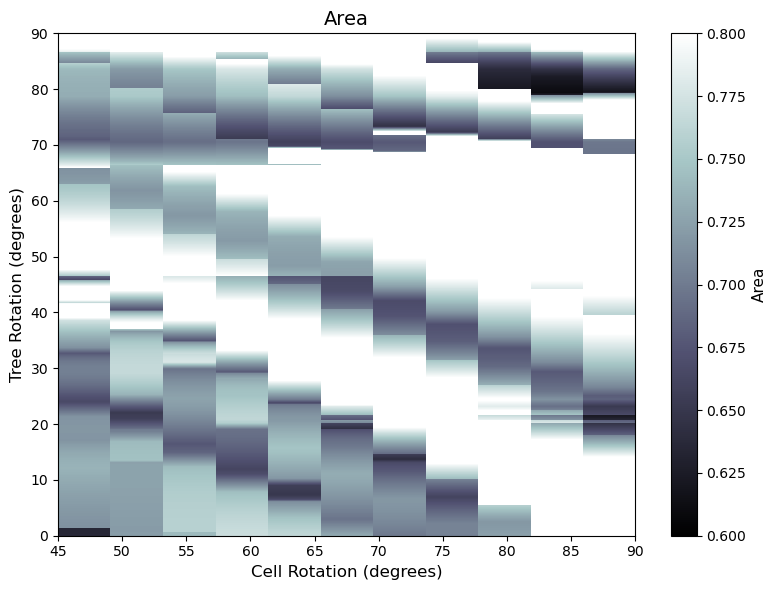

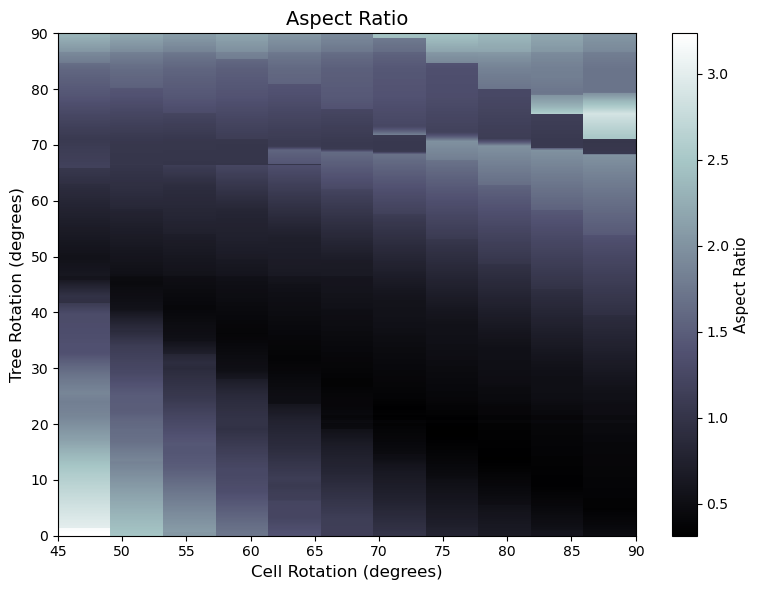

<Axes: title={'center': 'Aspect Ratio'}, xlabel='Cell Rotation (degrees)', ylabel='Tree Rotation (degrees)'>

In [4]:
import matplotlib.pyplot as plt
def plot_rotation_heatmap(data, rot_tree_vals, rot_cell_vals, title, cbar_label, clim=None):
    """Plot a heatmap of rotation analysis results."""
    # Convert radians to degrees for axis labels
    rot_tree_degrees = np.degrees(rot_tree_vals.get())
    rot_cell_degrees = np.degrees(rot_cell_vals.get())
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    im = ax.imshow(data, origin='lower', aspect='auto', cmap='bone',
                   extent=[rot_cell_degrees[0], rot_cell_degrees[-1], 
                          rot_tree_degrees[0], rot_tree_degrees[-1]], interpolation='none')
    ax.set_xlabel('Cell Rotation (degrees)', fontsize=12)
    ax.set_ylabel('Tree Rotation (degrees)', fontsize=12)
    ax.set_title(title, fontsize=14)
    if clim is not None:
        im.set_clim(*clim)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label, fontsize=11)
    
    plt.tight_layout()    
    plt.show()

    return ax

# Create two separate figures
ax = plot_rotation_heatmap(res_area, rot_tree_vals, rot_cell_vals, 
                      'Area', 'Area', clim=(0.6,0.8))


plot_rotation_heatmap(res_aspect_ratio, rot_tree_vals, rot_cell_vals, 
                      'Aspect Ratio', 'Aspect Ratio')

In [5]:
import tqdm
import pack_ga
importlib.reload(pack_dimer)
dimer = pack_dimer.create_dimer()
def relax_sol(sol, legalize=True):
    relaxer = pack_ga.GA().fine_relaxers[0]
    relaxer.cost.costs.pop(1)
    #relaxer.plot_interval = None
    relaxer.n_iterations*=50
    relaxer.max_step = 1e-4
    #pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
    #plt.pause(3)
    sol = relaxer.run_simulation(sol)
    if legalize:
        for _ in range(10):
            print(_)
            relaxer.cost.costs[0].scaling *= 0.5
            sol = relaxer.run_simulation(sol)
    return sol
rot_tree_vals = cp.array(np.arange(0, np.pi/2*kgs.just_over_one, np.pi/2000), dtype=kgs.dtype_cp)
sol_base = kgs.SolutionCollectionLatticeRectangle(xyt=dimer[None], h=cp.array([[3.,3.]], dtype=kgs.dtype_cp), do_snap=False)
sol_base.xyt = cp.tile(sol_base.xyt[0], (len(rot_tree_vals),1,1))
sol_base.h = cp.tile(sol_base.h[0], (len(rot_tree_vals),1))
sol_base.rotate(rot_tree_vals)
sol_base.check_constraints()       
sol = copy.deepcopy(sol_base)
pack_dimer.snap_cell(sol, skip_assert=False)
res_area2 = pack_cost.AreaCost().compute_cost_allocate(sol)[0].get()
res_aspect_ratio2 = (sol.h[:,0]/sol.h[:,1]).get()   
#pack_vis_sol.pack_vis_sol(sol, solution_idx=0)
sol_r = relax_sol(copy.deepcopy(sol))
res_area3 = pack_cost.AreaCost().compute_cost_allocate(sol_r)[0].get()
res_aspect_ratio3 = (sol_r.h[:,0]/sol_r.h[:,1]).get()


stop final relax at some point


/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


0
1
2
3
4
5
6
7
8
9


In [6]:
kgs.profiling=False
sol_p = kgs.dill_load(kgs.code_dir + '/../res/packings.pickle')
sol_p.xyt = sol_p.xyt.astype(kgs.dtype_cp)
sol_p.h = sol_p.h.astype(kgs.dtype_cp)
sol_p.aspect_ratios = sol_p.aspect_ratios.astype(kgs.dtype_cp)
sol_p = relax_sol(sol_p)

res_area4 = pack_cost.AreaCost().compute_cost_allocate(sol_p)[0].get()
res_aspect_ratio4 = sol_p.aspect_ratios.get()

0
1
2
3
4
5
6
7
8
9


(1001,)


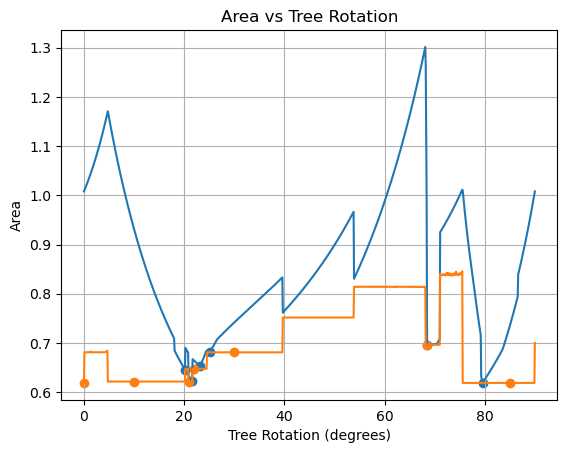

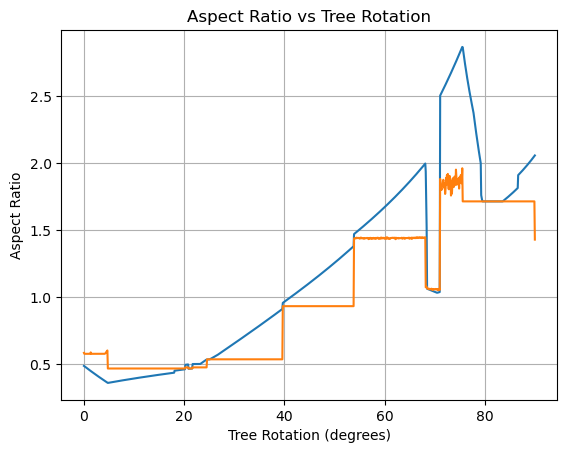

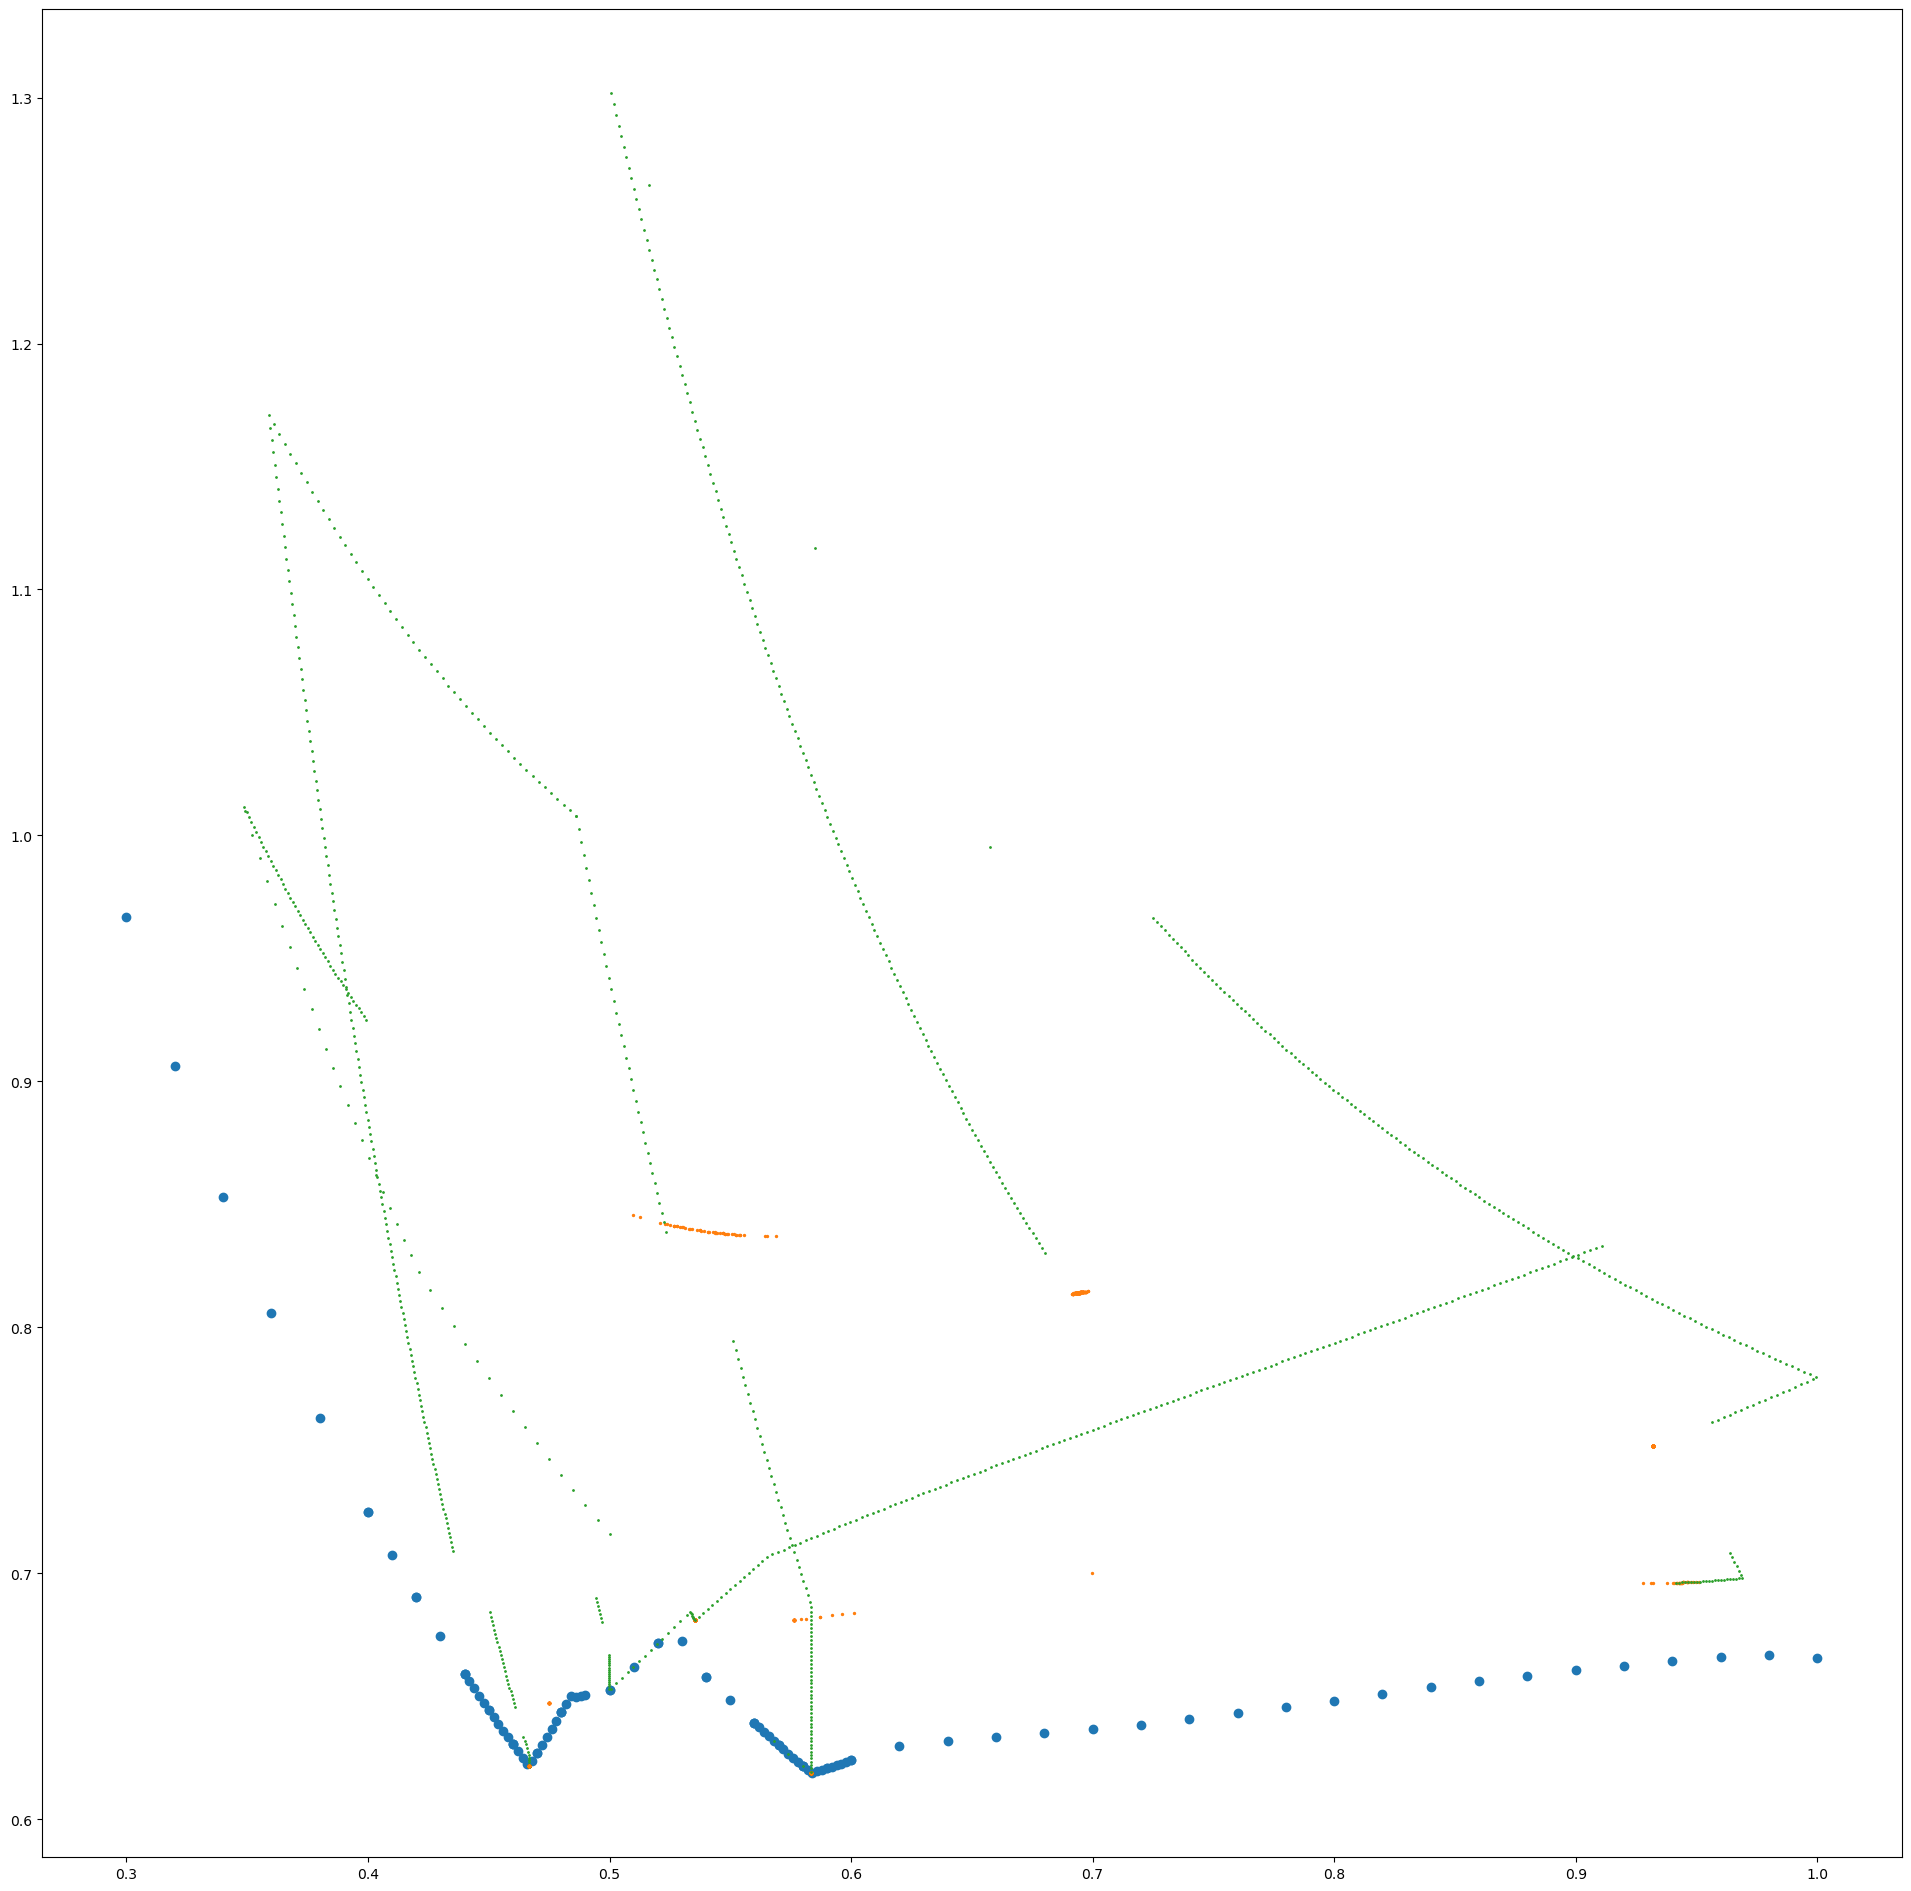

In [7]:
import mplcursors

fig1, ax1 = plt.subplots()
line1 = ax1.plot(np.degrees(rot_tree_vals.get()), res_area2)
ax1.plot(np.degrees(rot_tree_vals.get()), res_area3)
ax1.grid(True)
ax1.set_xlabel('Tree Rotation (degrees)')
ax1.set_ylabel('Area')
ax1.set_title('Area vs Tree Rotation')
mplcursors.cursor(line1, hover=True)

fig2, ax2 = plt.subplots()
line2 = ax2.plot(np.degrees(rot_tree_vals.get()), res_aspect_ratio2)
ax2.plot(np.degrees(rot_tree_vals.get()), res_aspect_ratio3)
ax2.grid(True)
ax2.set_xlabel('Tree Rotation (degrees)')
ax2.set_ylabel('Aspect Ratio')
ax2.set_title('Aspect Ratio vs Tree Rotation')
mplcursors.cursor(line2, hover=True)

from scipy.signal import find_peaks
a,b = find_peaks(-res_area2, height=-1000)
b=-b['peak_heights']
sel = b<0.7
a=a[sel]
rads_min = rot_tree_vals[a]
ax1.scatter(np.degrees(rads_min.get()),res_area2[a])
solx = copy.deepcopy(sol)
solx.xyt = solx.xyt[a]
solx.h = solx.h[a]
names = [f'{np.degrees(r.get()):.4f}' for r in rads_min]

print(res_area3.shape)
deg_vals = np.array([0., 10., 21., 22., 30., 68.5, 85.])
rad_vals = np.radians(deg_vals)
# find indices closest to rad_vals
a = [np.argmin(np.abs(rot_tree_vals.get() - rv)) for rv in rad_vals]
rads_min = rot_tree_vals[a]
ax1.scatter(np.degrees(rads_min.get()),res_area3[a])
solx.xyt = cp.concatenate((solx.xyt,sol_r.xyt[a]))
solx.h = cp.concatenate((solx.h,sol_r.h[a]))
names = names+[f'{np.degrees(r.get()):.4f}rel' for r in rads_min]

solx.xyt = cp.concatenate((solx.xyt,sol_p.xyt))
h_new = cp.array([ [sol_p.h[i,0], sol_p.aspect_ratios[i]*sol_p.h[i,0] ] for i in range(sol_p.N_solutions)], dtype=kgs.dtype_cp)
solx.h = cp.concatenate((solx.h,h_new))
solx.check_constraints()
names = names+[f'ga' for _ in range(sol_p.N_solutions)]

plt.figure(figsize=(24,24))
plt.scatter(np.minimum(res_aspect_ratio4, 1/res_aspect_ratio4), res_area4, label='Prepped')
plt.scatter(np.minimum(res_aspect_ratio3, 1/res_aspect_ratio3), res_area3, 2., label='After Relaxation')
plt.scatter(np.minimum(res_aspect_ratio2, 1/res_aspect_ratio2), res_area2, 1., label='Before Relaxation')


In [8]:
importlib.reload(pack_dimer)
best_trees_list = []
kgs.profiling=False
solutions_to_process = []
for i in range(solx.N_solutions):    
    this_sol = copy.deepcopy(solx)
    this_sol.xyt = this_sol.xyt[i:i+1]
    this_sol.h = this_sol.h[i:i+1]
    #plt.figure(figsize=(6,6))
    #pack_vis_sol.pack_vis_sol(this_sol)
    #plt.title(f'{names[i]}, Area: {pack_cost.AreaCost().compute_cost_allocate(this_sol)[0].get()[0]:.4f}, Aspect Ratio: {this_sol.h[0,0]/this_sol.h[0,1]:.4f}')
    #plt.show()
    solutions_to_process.append(this_sol)

len(solutions_to_process)


115

In [9]:
# %%time
# pack_dimer.try_tilings(solutions_to_process[0]);


CPU times: user 17.4 s, sys: 2.3 s, total: 19.7 s
Wall time: 20.5 s


In [10]:
# import multiprocess
# multiprocess.set_start_method('spawn', force=True)
# with multiprocess.Pool(processes=6) as pool:
#     best_trees_list = pool.map(pack_dimer.try_tilings, solutions_to_process)

# kgs.dill_save(kgs.temp_dir + 'best_trees_list.pickle', best_trees_list)

In [11]:
best_trees_list = kgs.dill_load(kgs.temp_dir + 'best_trees_list.pickle')

In [12]:
import pack_io
importlib.reload(pack_io)
import pandas as pd
[sol_list_ref, scores] = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.temp_dir + '71.66.csv'))
#[sol_list_ref2, scores2] = pack_io.dataframe_to_solution_list(pd.read_csv(kgs.temp_dir + '71.66.csv'))
#for s in sol_list_ref:
#    s.rotate(-np.pi/2)

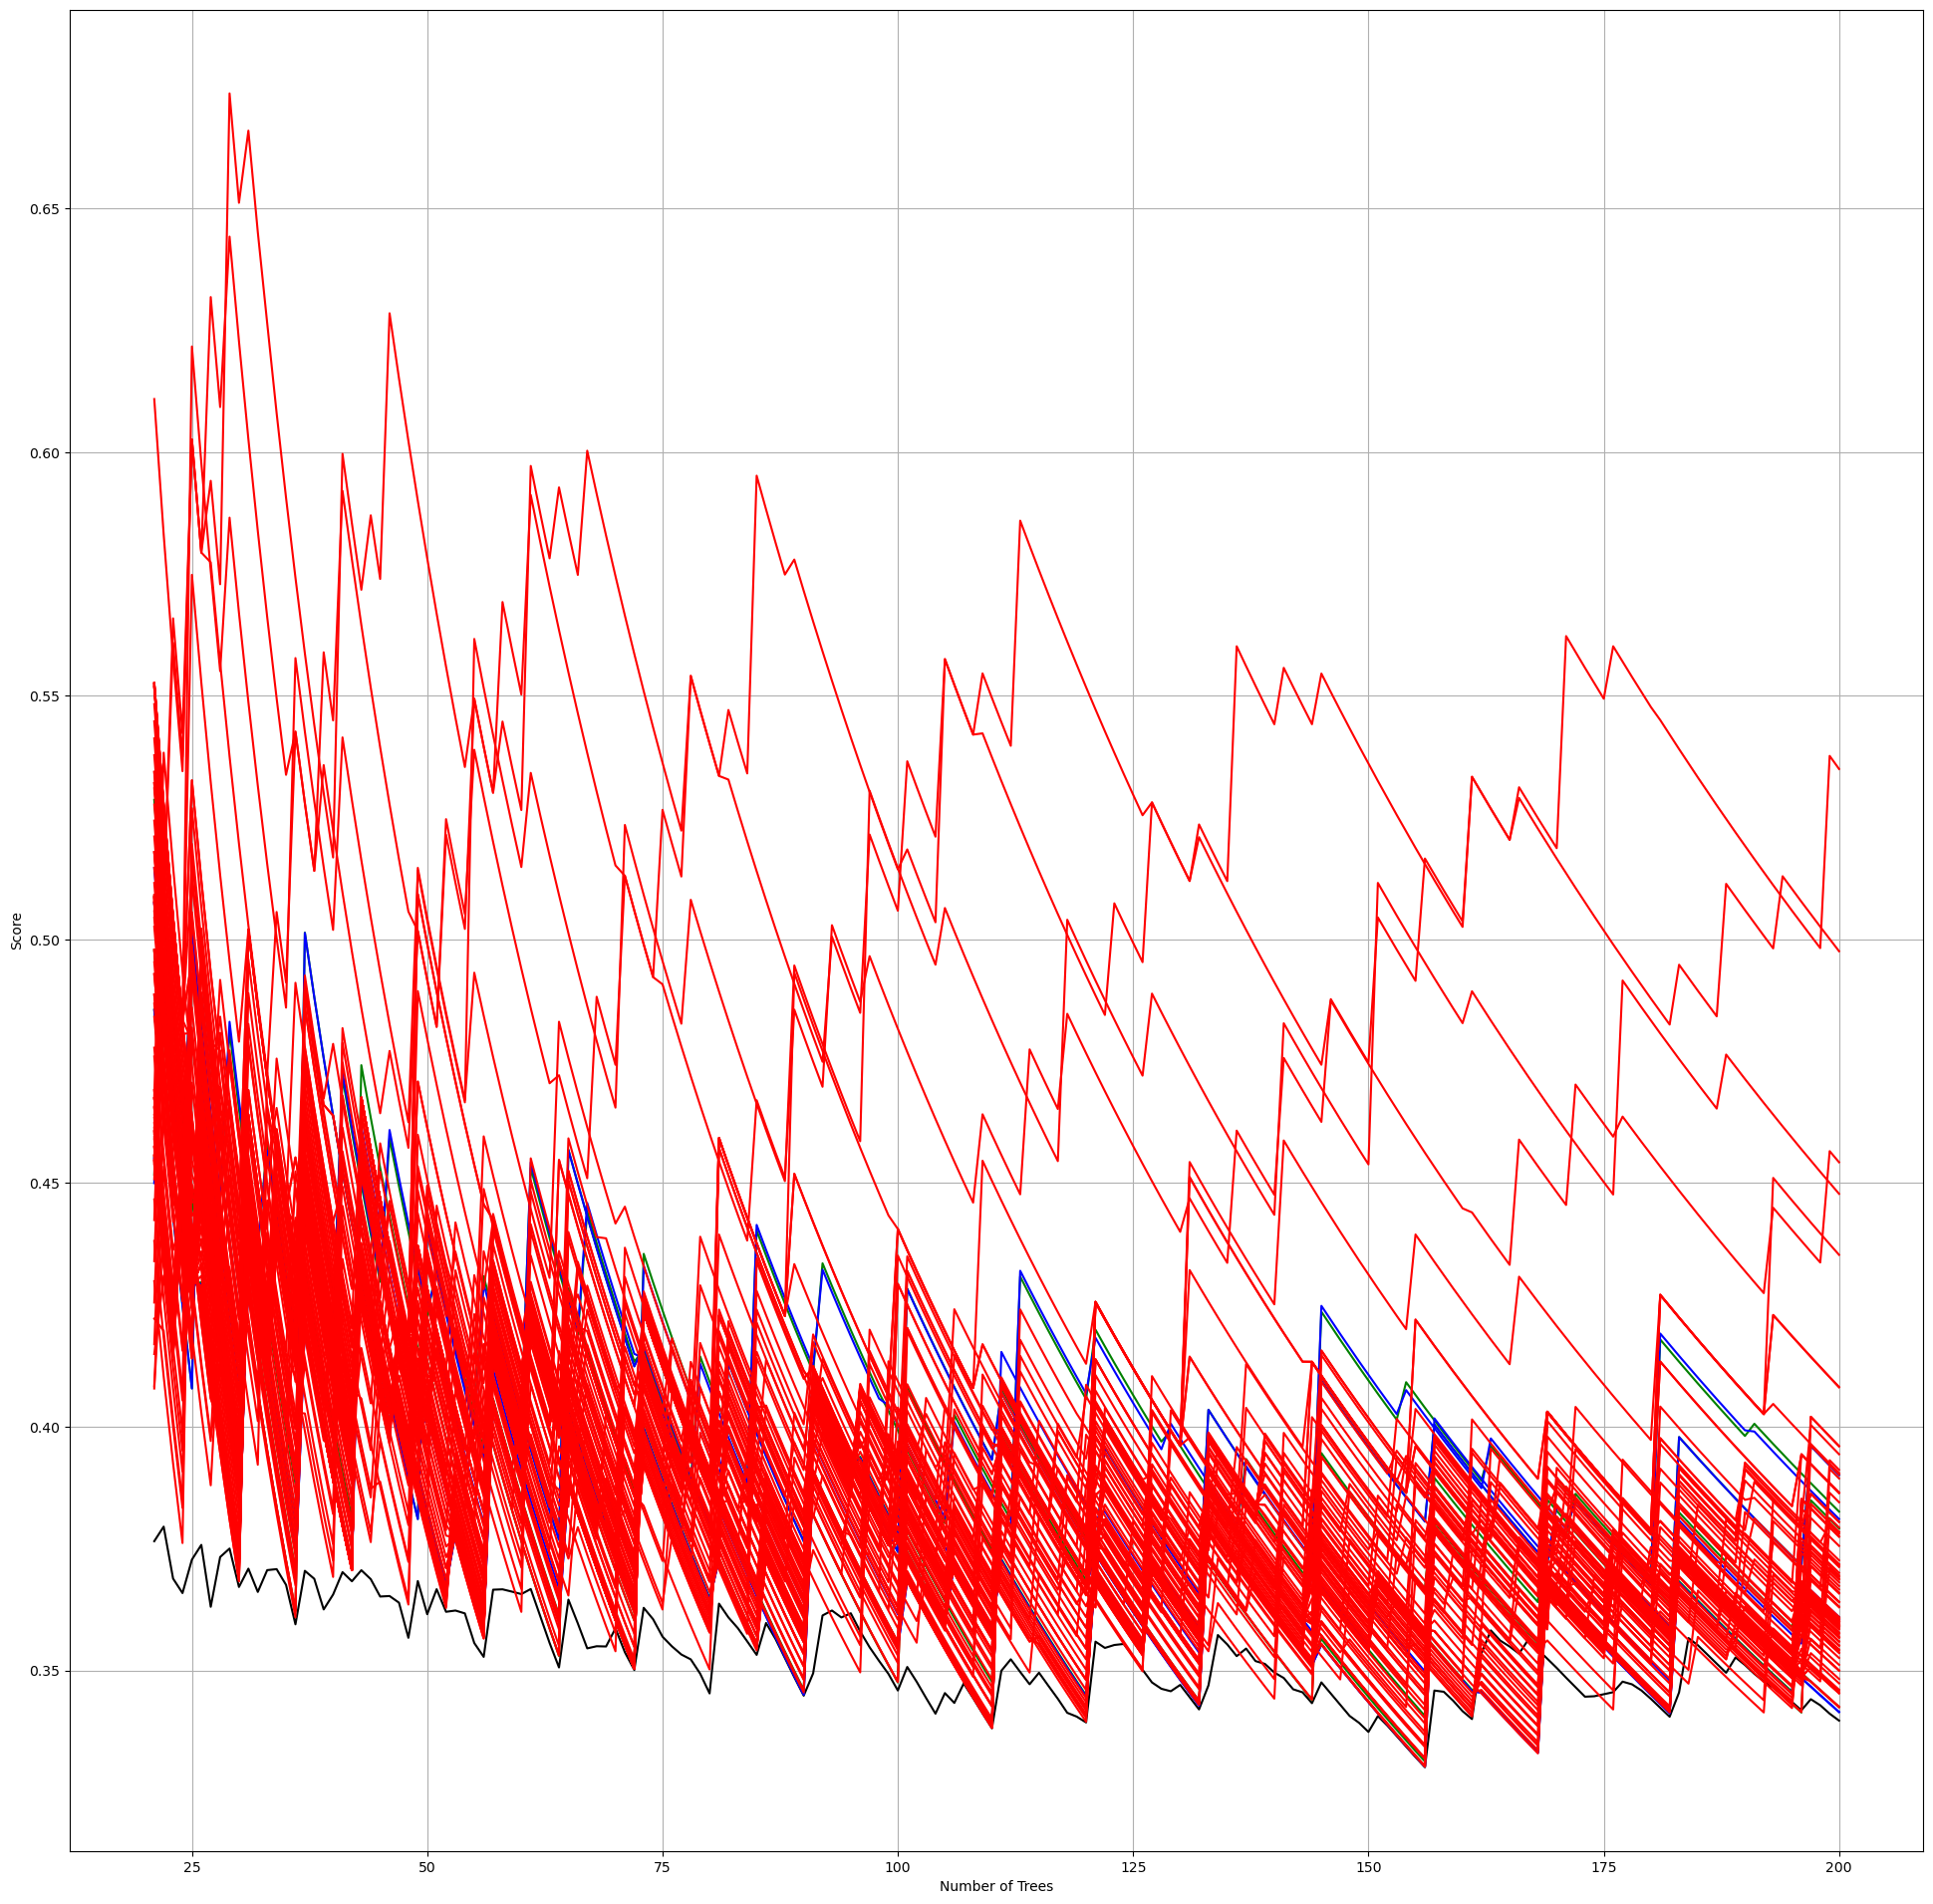

In [13]:
plt.figure(figsize=(24,24))
N_trees = np.arange(1,201)
N=20
lines = []
vals_res = np.array([np.inf]*200)
#line = plt.plot(N_trees[N:], scores[N:], 'k')
line = plt.plot(N_trees[N:], scores[N:], 'k')
lines.extend(line)
for b,n in zip(best_trees_list, names):
    this_vals = b[0]**2/N_trees
    vals_res = np.minimum(vals_res, this_vals)
    if 'rel' in n: 
        line = plt.plot(N_trees[N:], this_vals[N:], 'b')
    elif 'ga' in n:
        line = plt.plot(N_trees[N:], this_vals[N:], 'r')
    else:
        line = plt.plot(N_trees[N:], this_vals[N:], 'g')
    lines.extend(line)
plt.grid(True)
#plt.legend(['ref']+names)
plt.xlabel('Number of Trees')
plt.ylabel('Score')

# Add interactive cursor for all lines
mplcursors.cursor(lines, hover=True)

In [14]:
overall_best = []
overall_best_score = []
for i_tree in range(200):
    best_id = np.argmin([b[0][i_tree] for b in best_trees_list])
    best_sol = best_trees_list[best_id][1][i_tree]
    overall_best.append(best_sol)
    overall_best_score.append( (best_sol.h[0,0]**2/best_sol.N_trees).get())

In [15]:
import pack_io
import boolean_line_search
import pack_metric
importlib.reload(boolean_line_search)
importlib.reload(pack_io)
importlib.reload(pack_metric)
#x=pack_io.solution_list_to_dataframe(overall_best)
#x
#x.to_csv(kgs.temp_dir + 'submission.csv', index=False)

<module 'pack_metric' from '/mnt/d/packing/code/analysis/../core/pack_metric.py'>

In [16]:
# from tqdm import tqdm
# import os, time
# import multiprocess

# multiprocess.set_start_method("spawn", force=True)

# def init_worker(base_delay=10.0):
#     # Each worker sleeps a different amount once
#     # (pid-based hash to avoid all workers sleeping the same)
#     import os
#     import time
#     pid = os.getpid()
#     slot = pid%10
#     time.sleep(base_delay * slot)

# def do_one(sol):
#     import pack_io
#     import kaggle_support as kgs
#     kgs.set_float32(True)
#     return pack_io.legalize(sol, move_factor=100., tolerance_rel_change=1e-7, do_plot=False)

# with multiprocess.Pool(processes=10, initializer=init_worker, initargs=(10.0,)) as pool:
#     overall_best_legalized = list(
#         tqdm(pool.imap(do_one, overall_best),
#              total=len(overall_best), desc="Legalizing")
#     )

# kgs.dill_save(kgs.code_dir + '../res/tess_legalized.pickle', overall_best_legalized) 
overall_best_legalized = kgs.dill_load(kgs.code_dir + '../res/tess_legalized.pickle') 
overall_best_legalized_score = [(x.h[0,0]**2/x.N_trees).get() for x in overall_best_legalized]

(np.float64(71.65614508068765),
 np.float32(72.19834),
 np.float64(71.11267297433531))

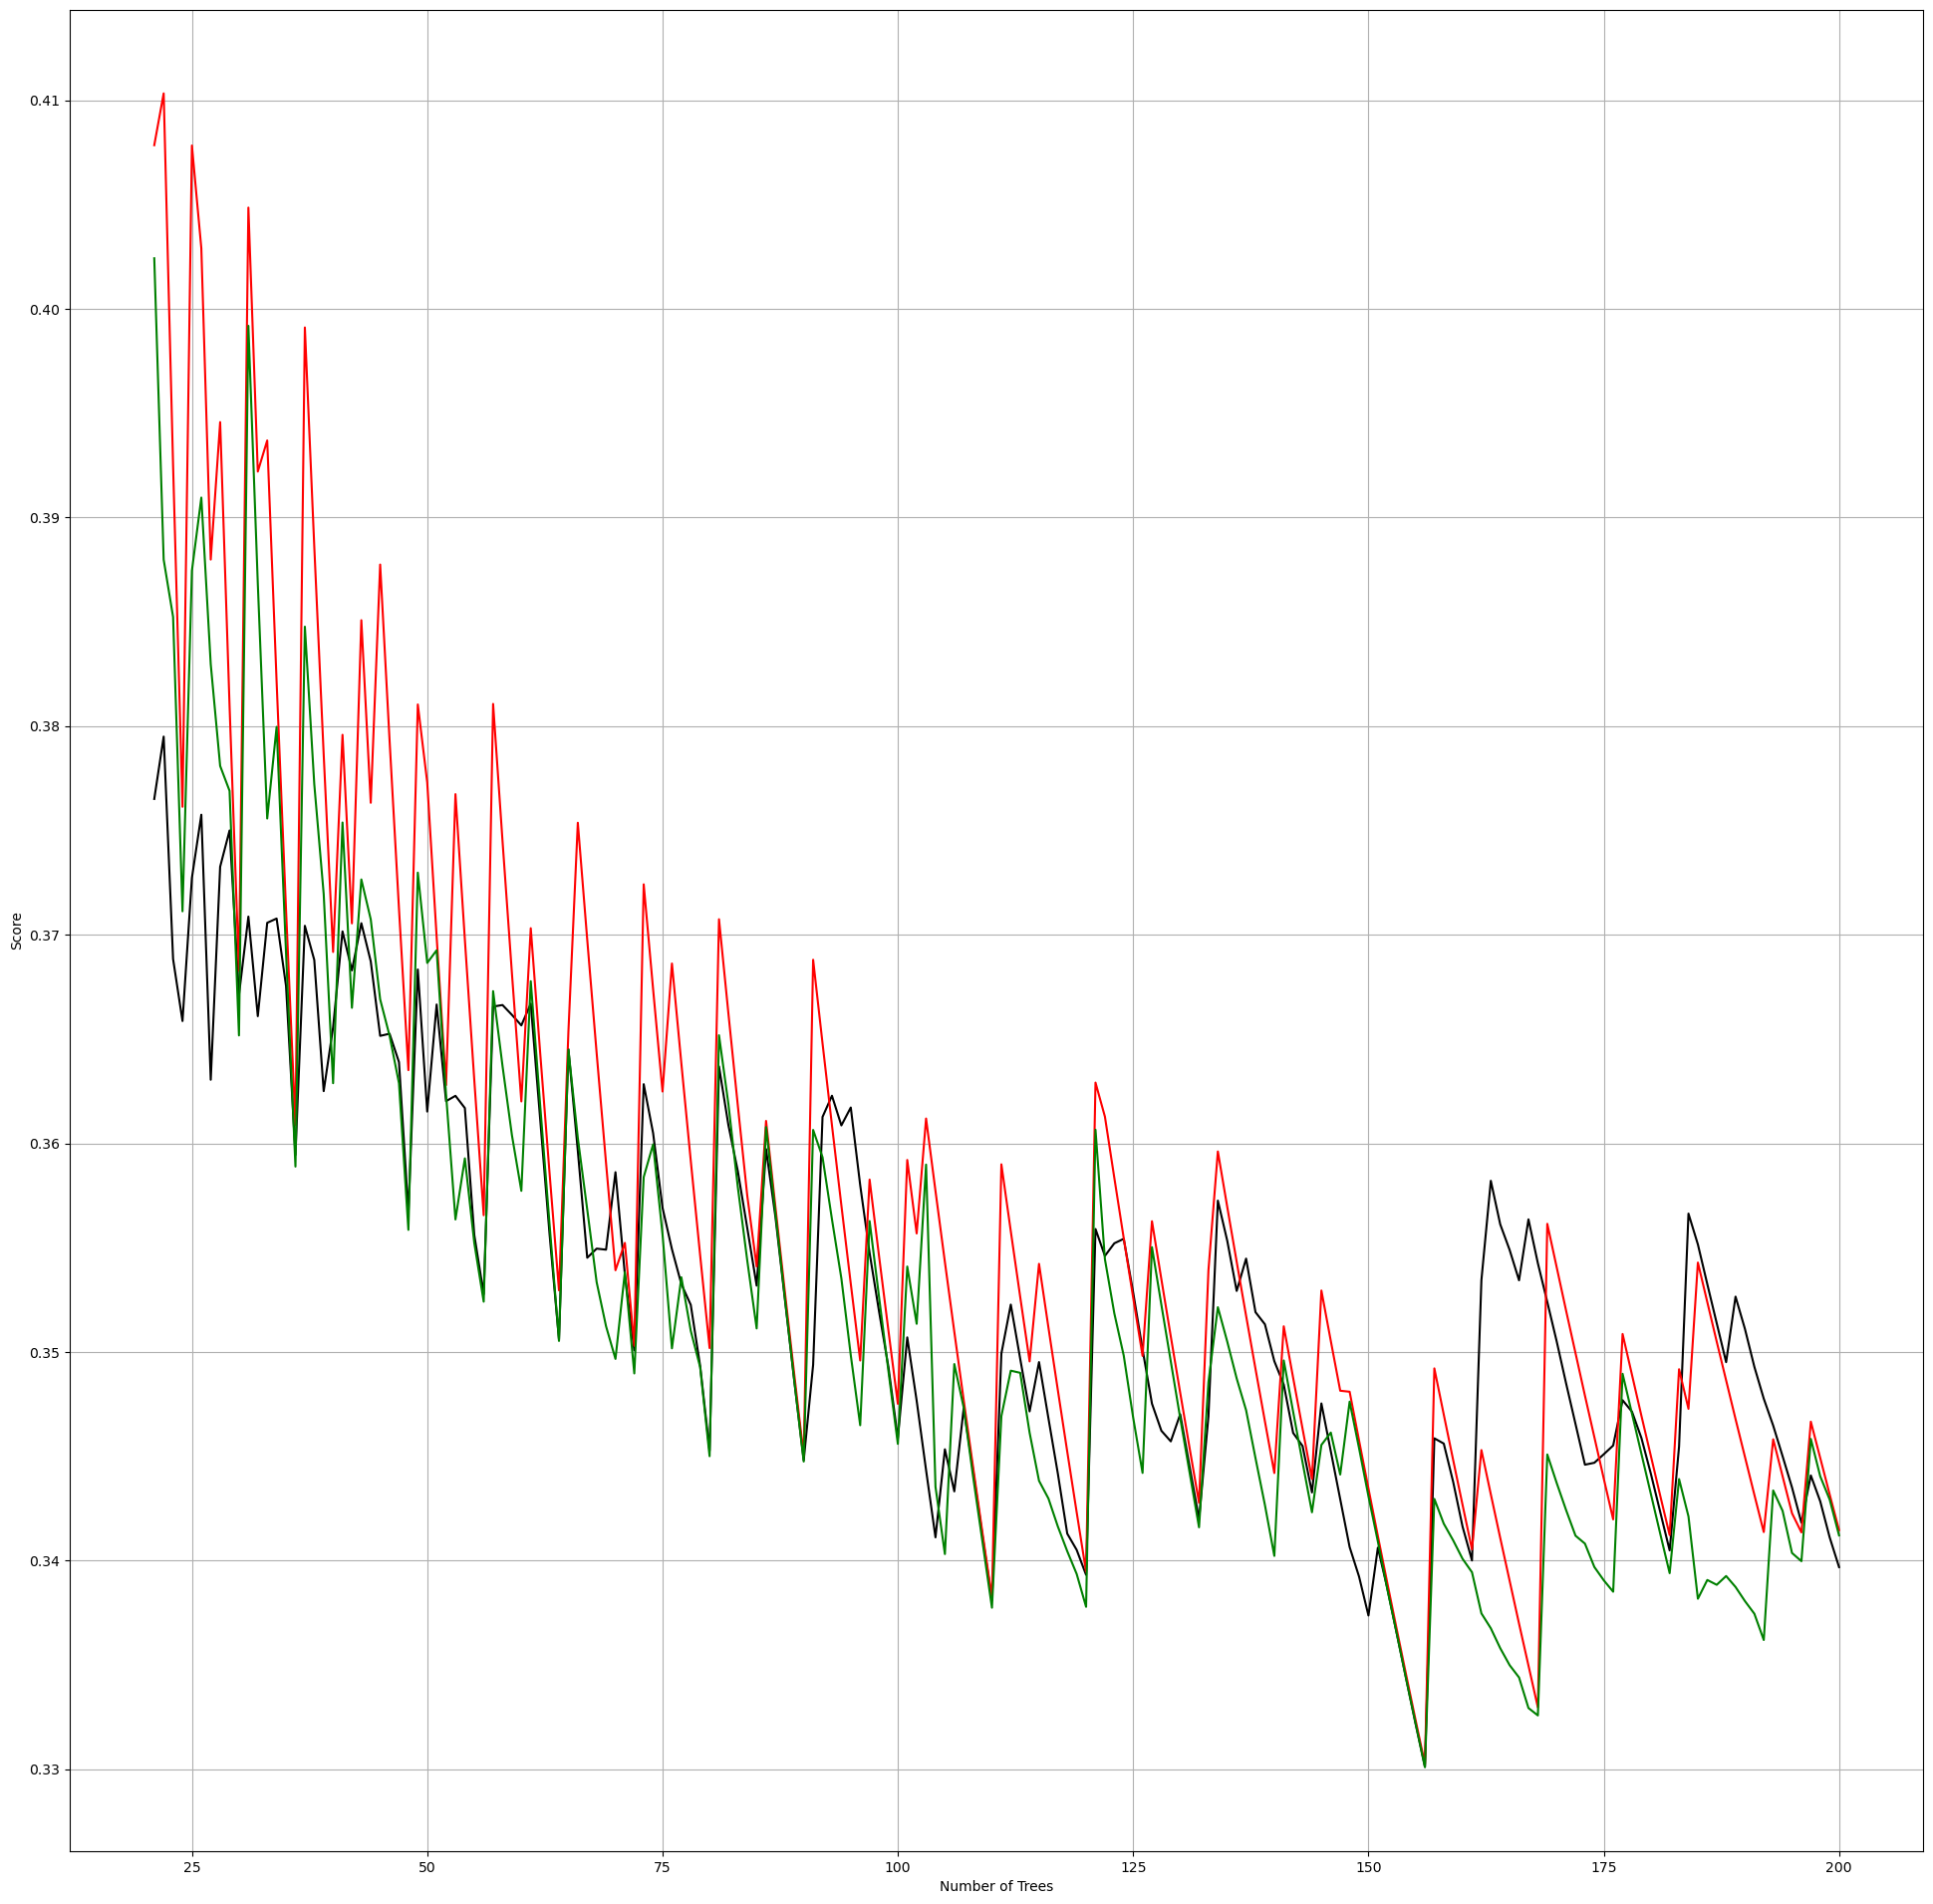

In [17]:
plt.figure(figsize=(24,24))
N_trees = np.arange(1,201)
N=20
lines = []
vals_res = np.array([np.inf]*200)
line = plt.plot(N_trees[N:], scores[N:], 'k')
lines.extend(line)
line = plt.plot(N_trees[N:], overall_best_score[N:], 'r')
lines.extend(line)   
line = plt.plot(N_trees[N:], overall_best_legalized_score[N:], 'g')
lines.extend(line)   
plt.grid(True)
#plt.legend(['ref']+names)
plt.xlabel('Number of Trees')
plt.ylabel('Score')

# Add interactive cursor for all lines
mplcursors.cursor(lines, hover=True)

np.sum(scores), np.sum(overall_best_legalized_score), np.sum(np.minimum(scores, overall_best_legalized_score))

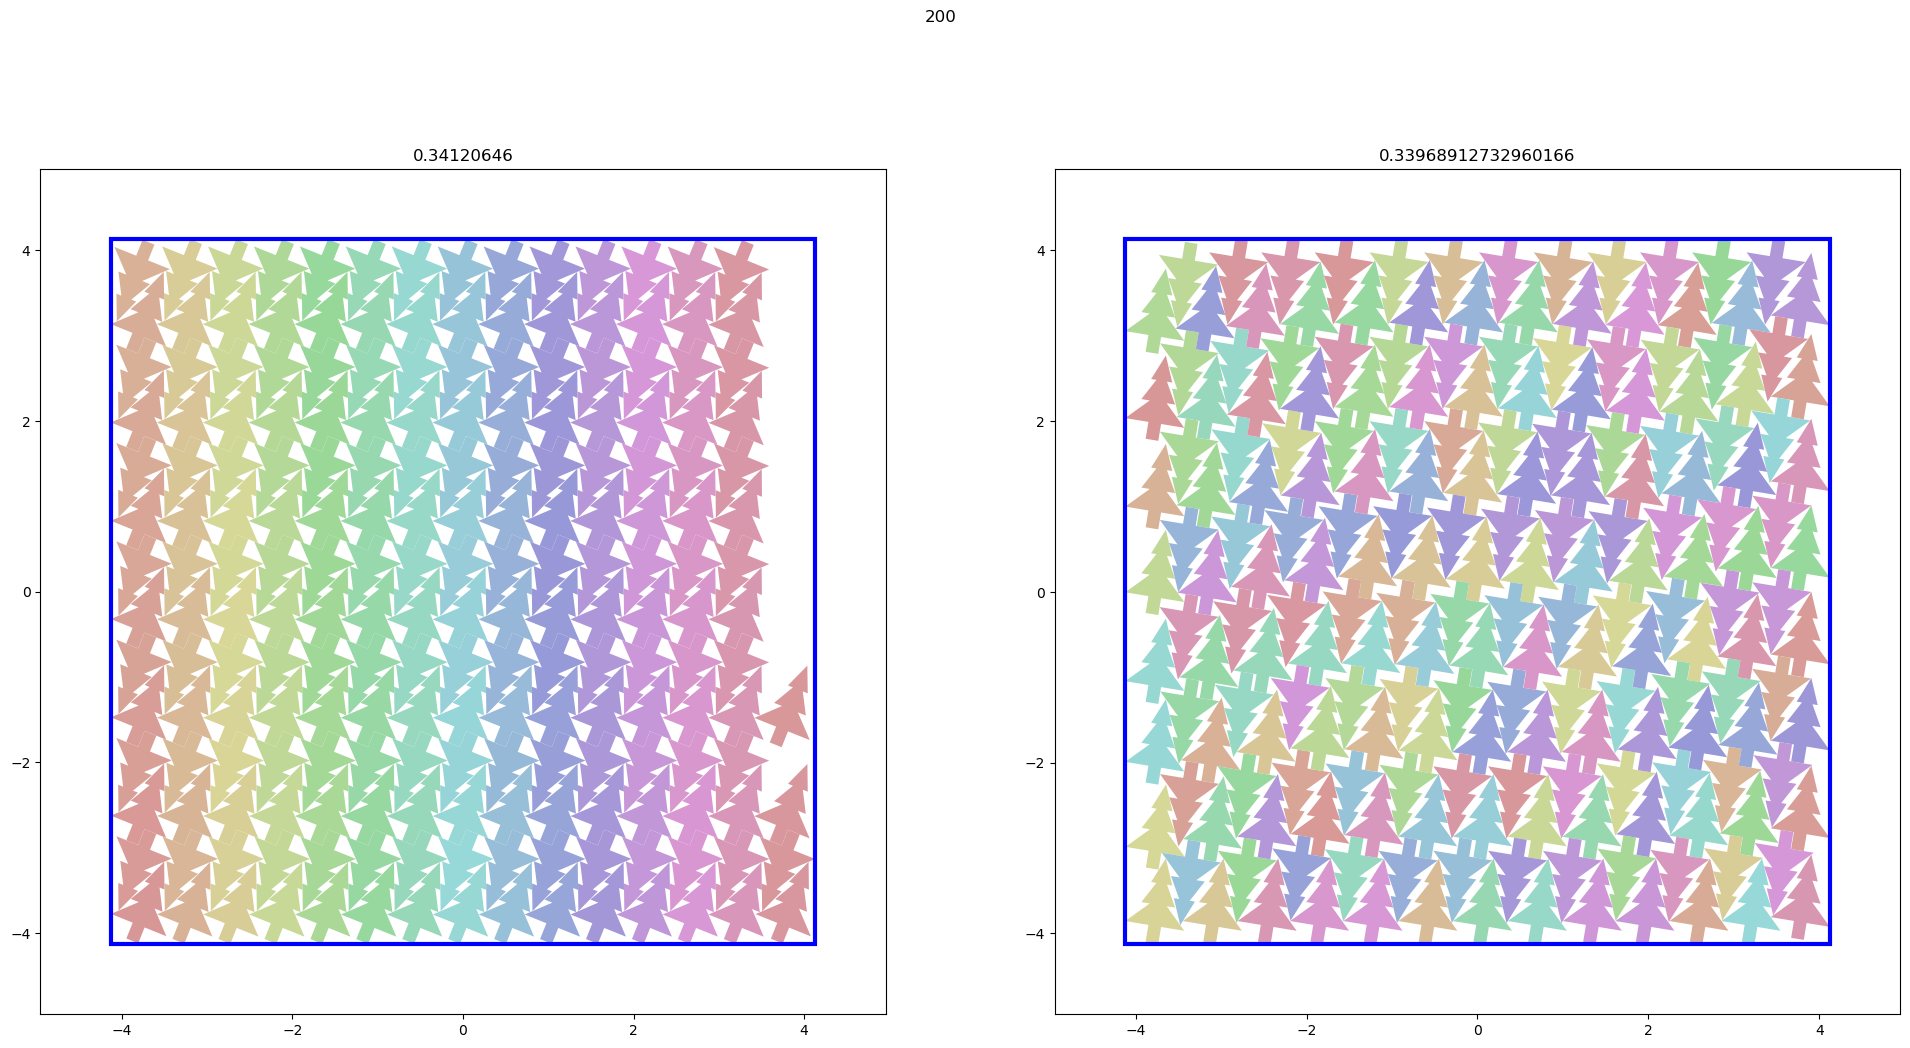

In [18]:
for N in [200]:
    _,ax = plt.subplots(1,2,figsize=(24,12))
    pack_vis_sol.pack_vis_sol(overall_best_legalized[N-1], solution_idx=0, ax=ax[0])
    plt.sca(ax[0])
    plt.title(overall_best_legalized[N-1].h[0,0]**2/overall_best[N-1].N_trees)
    sol2 = copy.deepcopy(sol_list_ref[N-1])
    sol2.rotate(cp.array([-np.pi/2]))
    sol2.snap()
    #sol2.xyt = cp.concatenate((overall_best[N-1].xyt, sol2.xyt), axis=1)
    pack_vis_sol.pack_vis_sol(sol2, solution_idx=0, ax=ax[1])
    plt.sca(ax[1])
    plt.title(sol_list_ref[N-1].h[0,0]**2/overall_best[N-1].N_trees)
    plt.suptitle(N)

In [19]:
import pack_io
pd = pack_io.solution_list_to_dataframe(overall_best_legalized)
pd.to_csv(kgs.temp_dir + 'submission.csv', index=False)

KeyboardInterrupt: 

In [ ]:
for i,s in enumerate(overall_best_legalized):
    print(i, pack_cost.CollisionCostSeparation().compute_cost_allocate(s)[0].get())
    pack_io.solution_list_to_dataframe([s],compact=False)


0 [4.6798715e-10]
Score of generated dataframe: 0.3453854374262598
1 [1.5279392e-10]
Score of generated dataframe: 0.34307886549310723
2 [1.3533367e-10]
Score of generated dataframe: 0.34090958950987293
3 [2.426757e-10]
Score of generated dataframe: 0.33863744508077426
4 [4.229339e-10]
Score of generated dataframe: 0.3365189024837615
5 [7.701692e-11]
Score of generated dataframe: 0.33433721528836075
6 [2.1384233e-10]
Score of generated dataframe: 0.3322253216054605
7 [2.1949675e-10]
Score of generated dataframe: 0.3300910267279016
8 [1.00718135e-10]
Score of generated dataframe: 0.3429541795133668
9 [1.2000667e-10]
Score of generated dataframe: 0.34176596982659957
10 [8.126534e-11]
Score of generated dataframe: 0.34096590541943184
11 [7.330563e-11]
Score of generated dataframe: 0.34007981930382497
12 [1.7164664e-10]
Score of generated dataframe: 0.33943792504341747
13 [7.769247e-11]
Score of generated dataframe: 0.33746709180842344
14 [1.2571832e-10]
Score of generated dataframe: 0.336

ParticipantVisibleError: Overlapping trees in group 177

Before optimization:  0.5151768922805786 4.198897229912291e-09 7.1775827


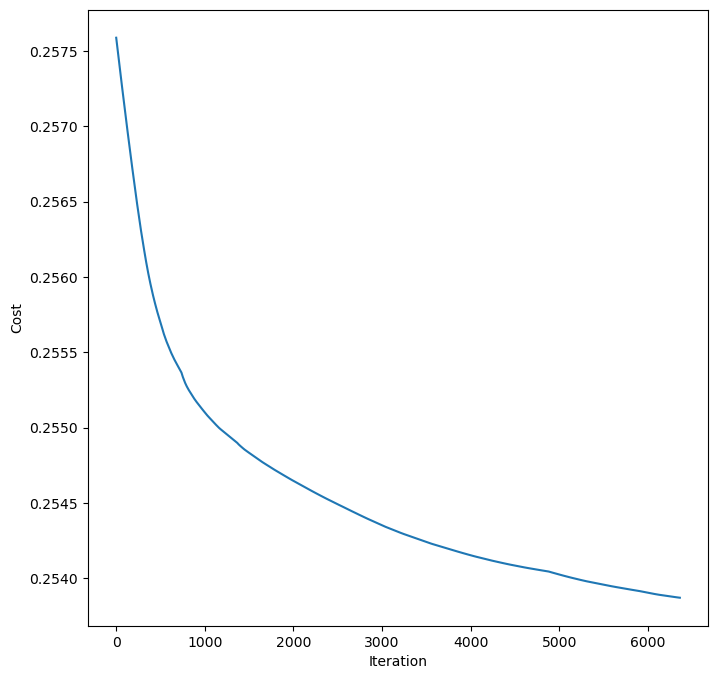

After optimization:  0.5062179565429688 0.0015251529403030872 7.1041737


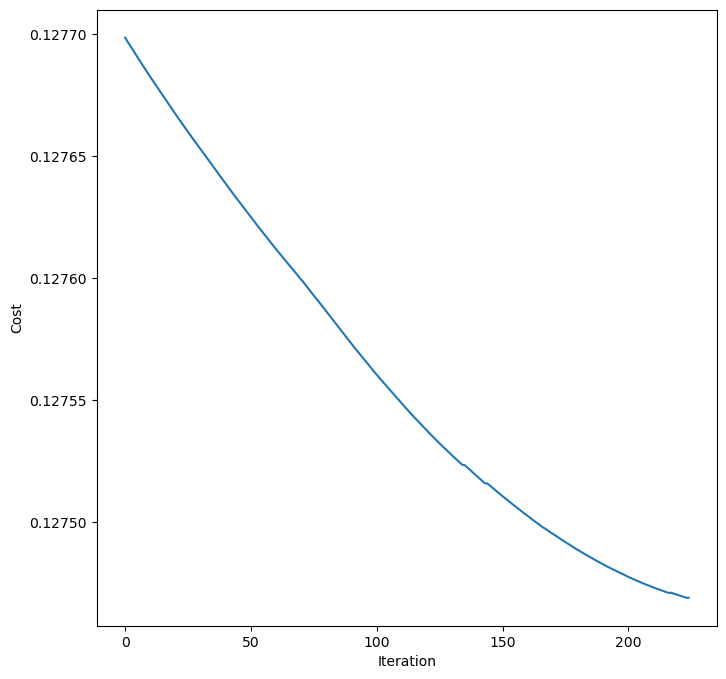

After optimization:  0.5071671009063721 0.0009029583306983113 7.1152244


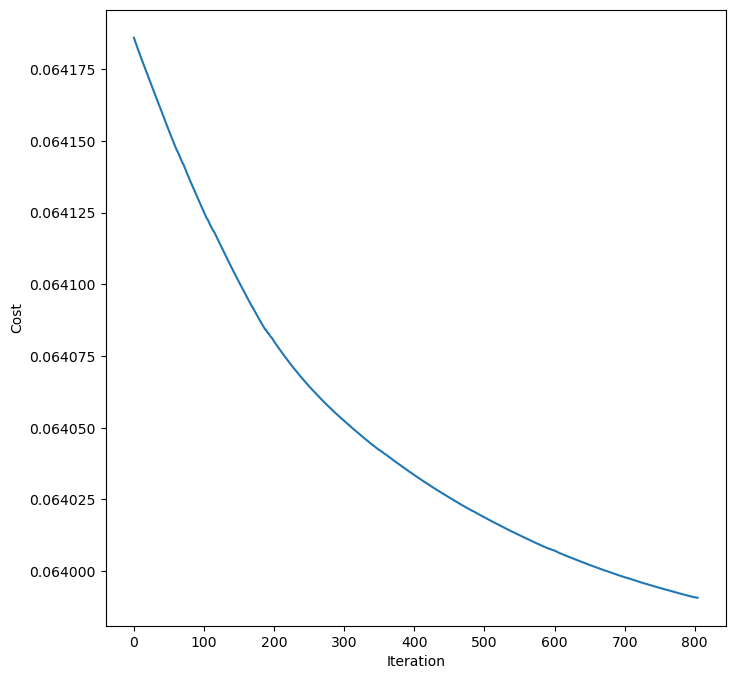

After optimization:  0.5093204975128174 0.000372217851690948 7.134061


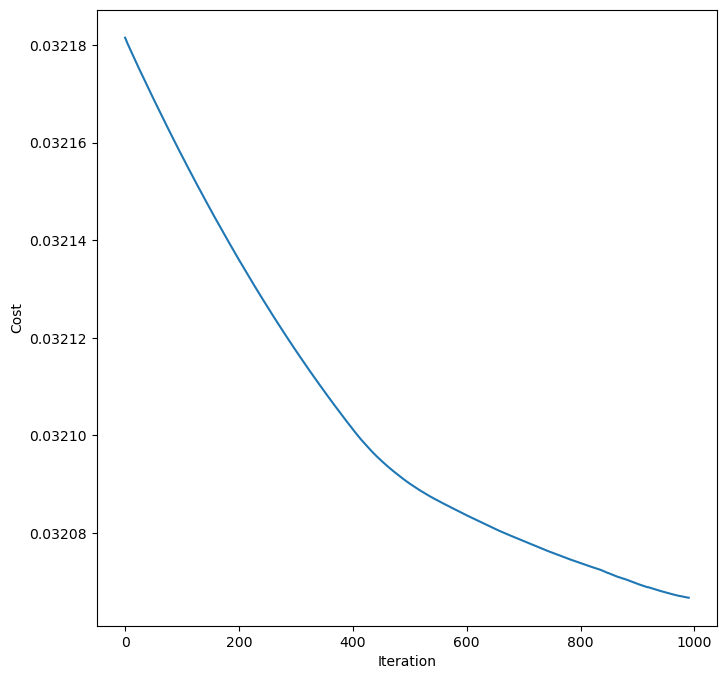

After optimization:  0.5116407871246338 9.516542195342481e-05 7.1522417


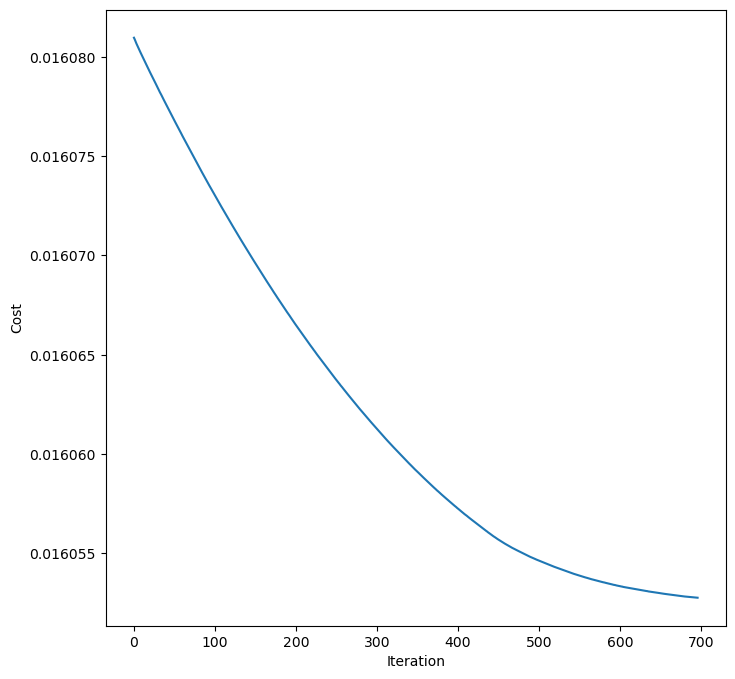

After optimization:  0.5130642652511597 2.0132501958869398e-05 7.16271


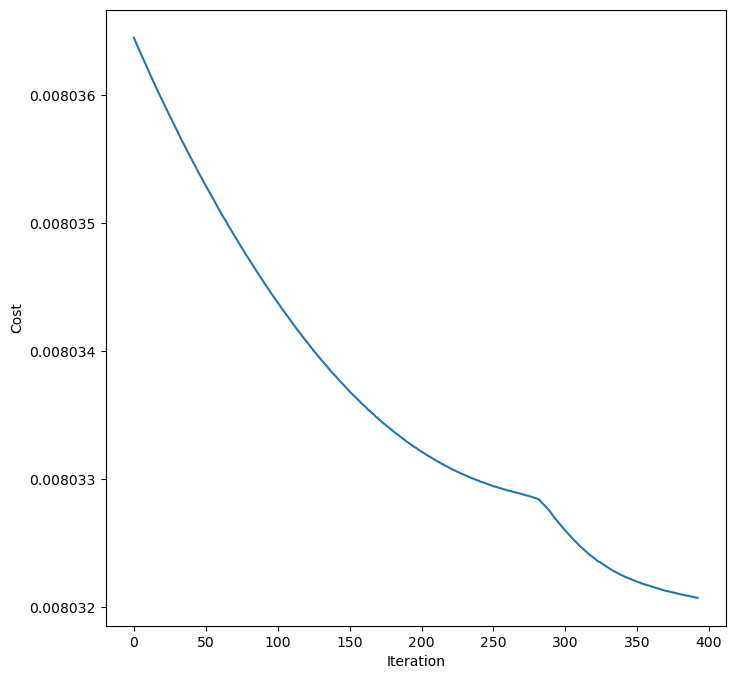

After optimization:  0.5136973857879639 5.640401013806695e-06 7.167229


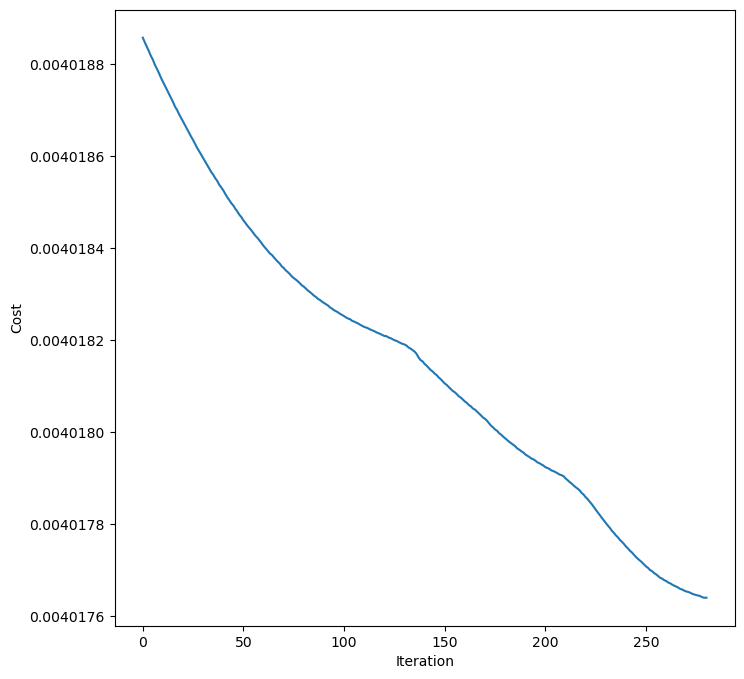

After optimization:  0.5140457153320312 1.6705830603314098e-06 7.1696863


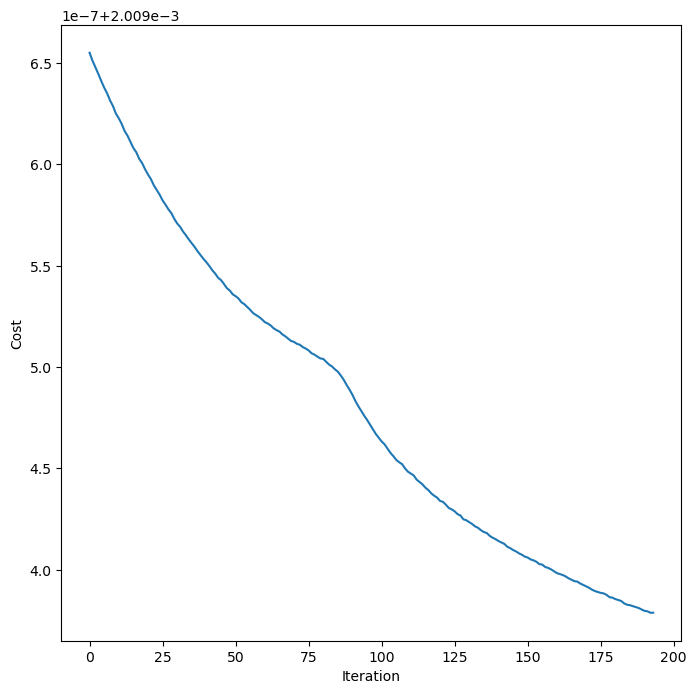

After optimization:  0.5141677260398865 9.144232535618357e-07 7.1705427


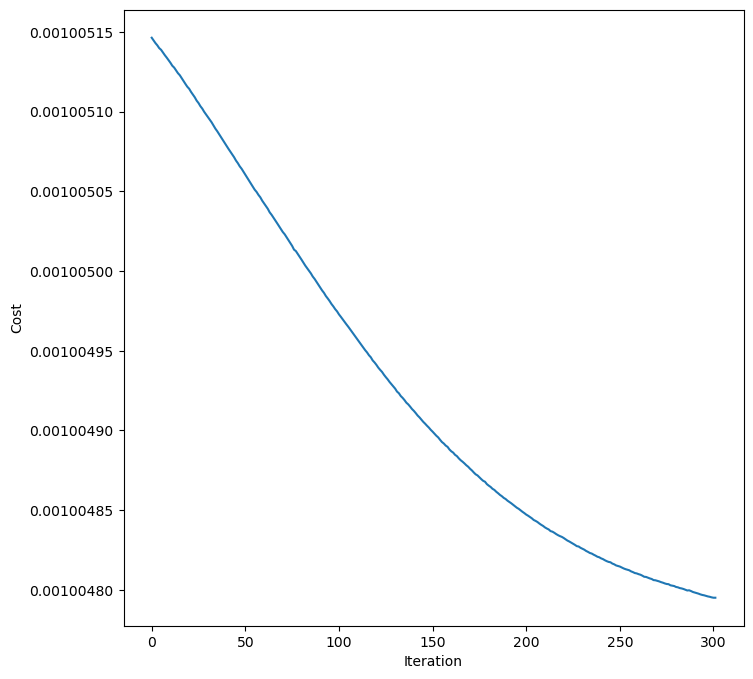

After optimization:  0.5143516063690186 2.0239080811279564e-07 7.1718297


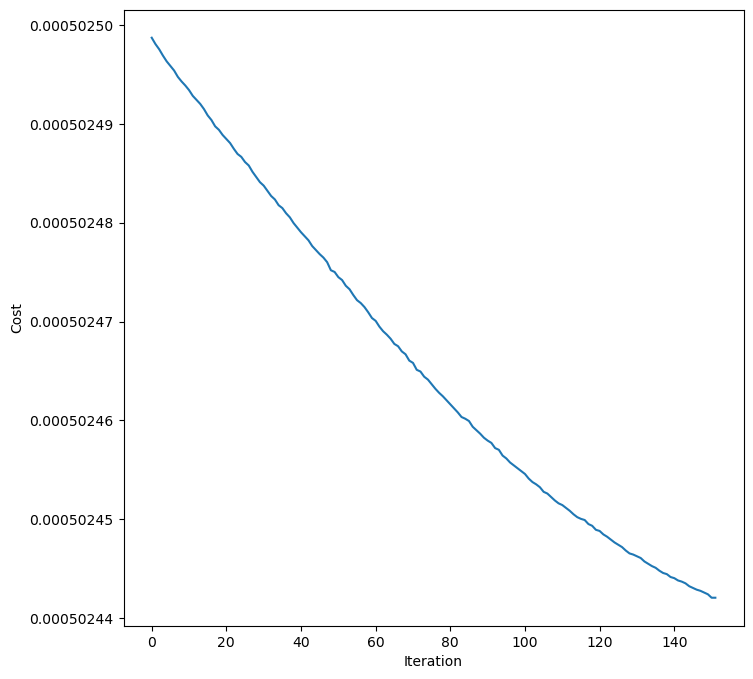

After optimization:  0.5144237875938416 7.517561328995725e-08 7.1723337


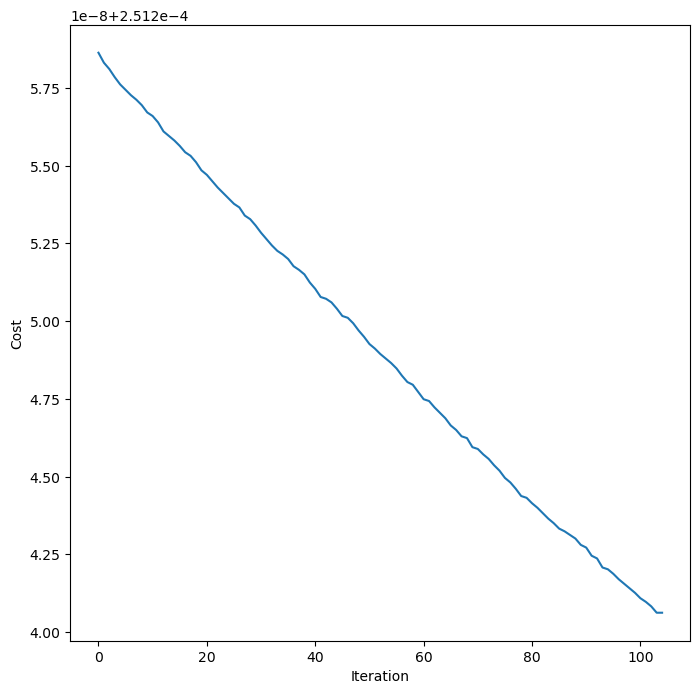

After optimization:  0.5144593715667725 3.9800362117148325e-08 7.1725817


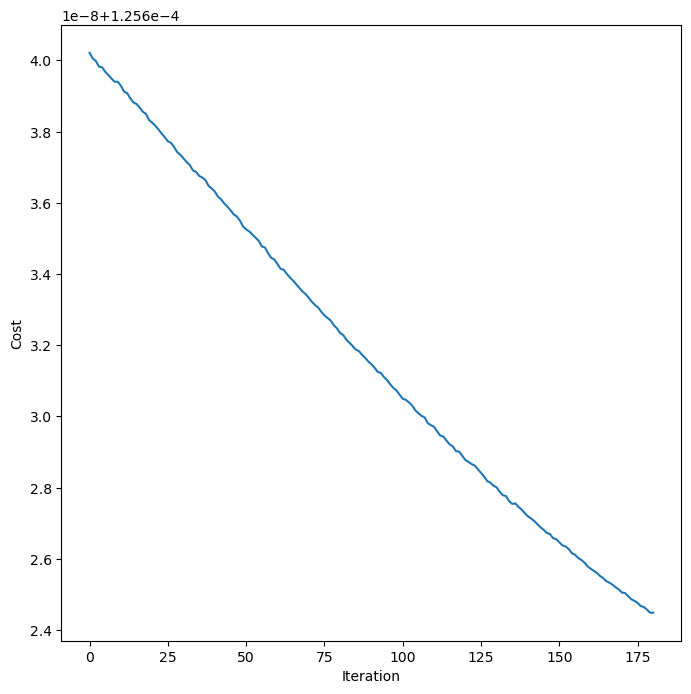

After optimization:  0.5144962072372437 1.5051799806542476e-08 7.172839


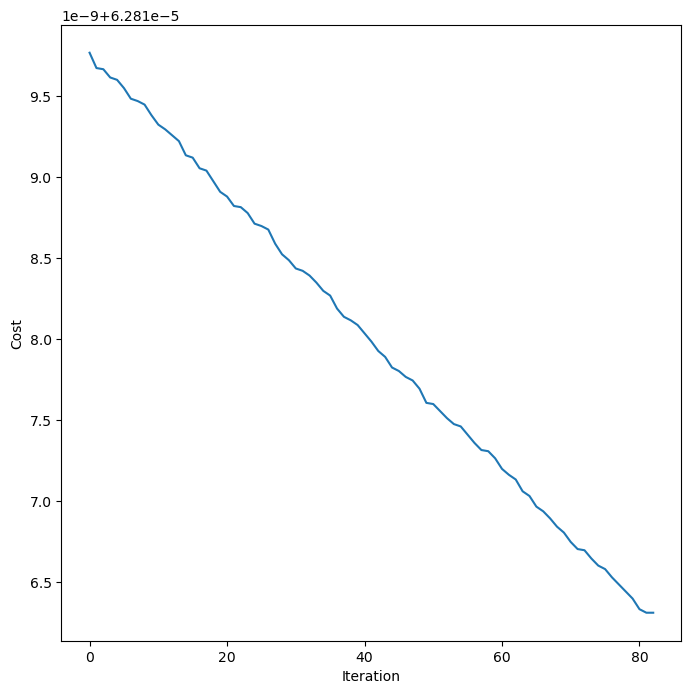

After optimization:  0.5145074129104614 1.0230061242566535e-08 7.1729174


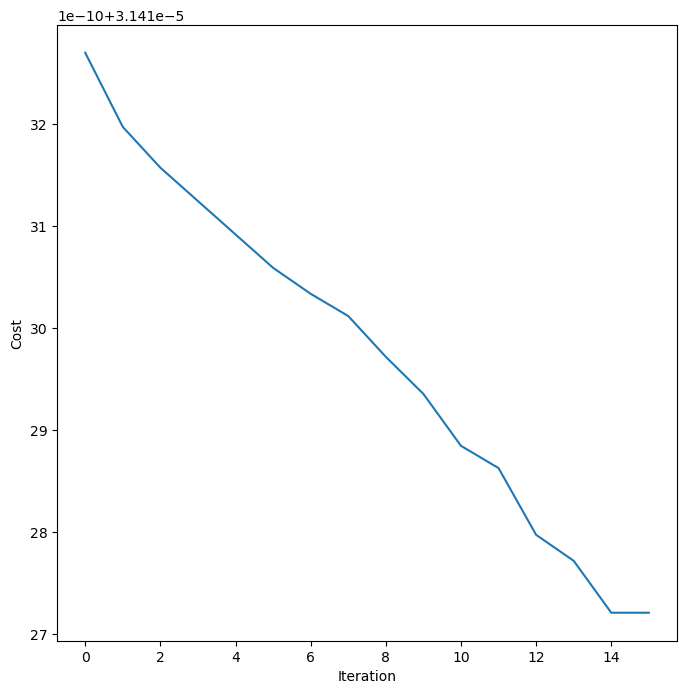

After optimization:  0.5145094394683838 9.557480140642838e-09 7.1729317


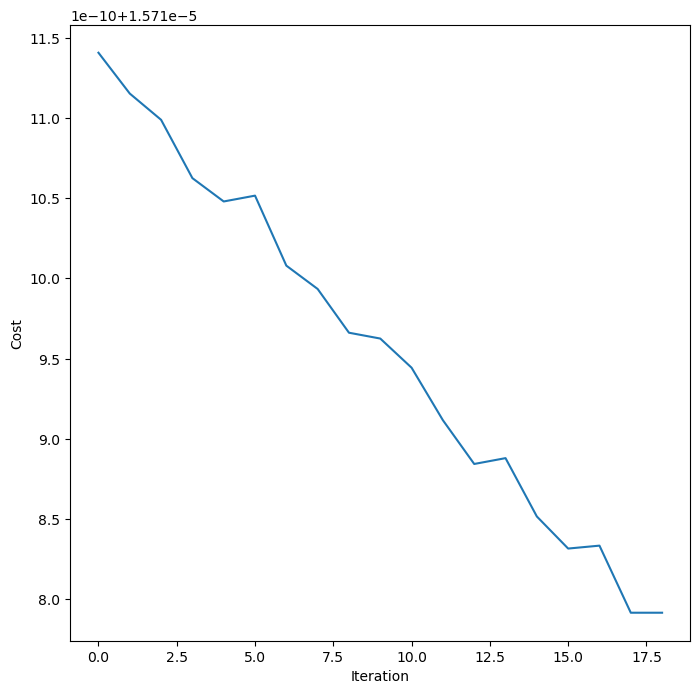

After optimization:  0.5145106911659241 9.170089576571172e-09 7.1729403


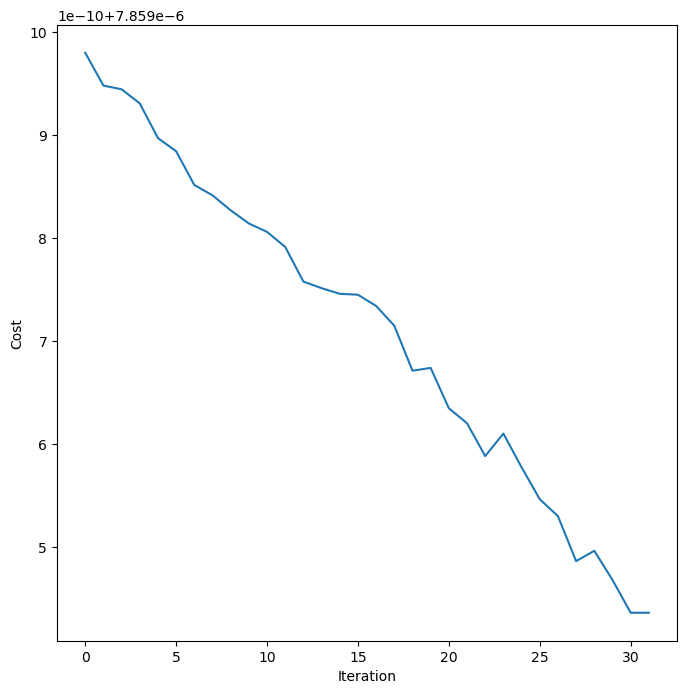

After optimization:  0.514512836933136 8.594083666935148e-09 7.172955


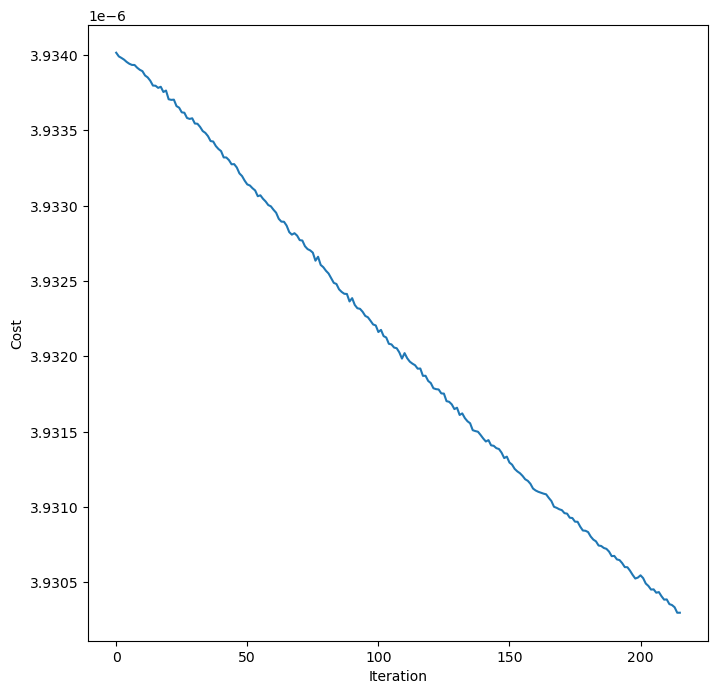

After optimization:  0.5145266652107239 4.7723021090462225e-09 7.1730514


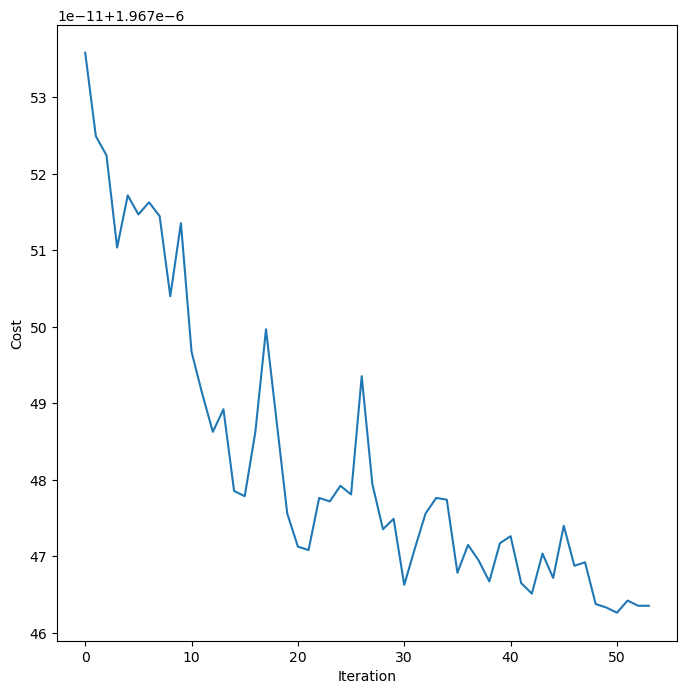

After optimization:  0.5145266652107239 4.699978628508461e-09 7.1730514


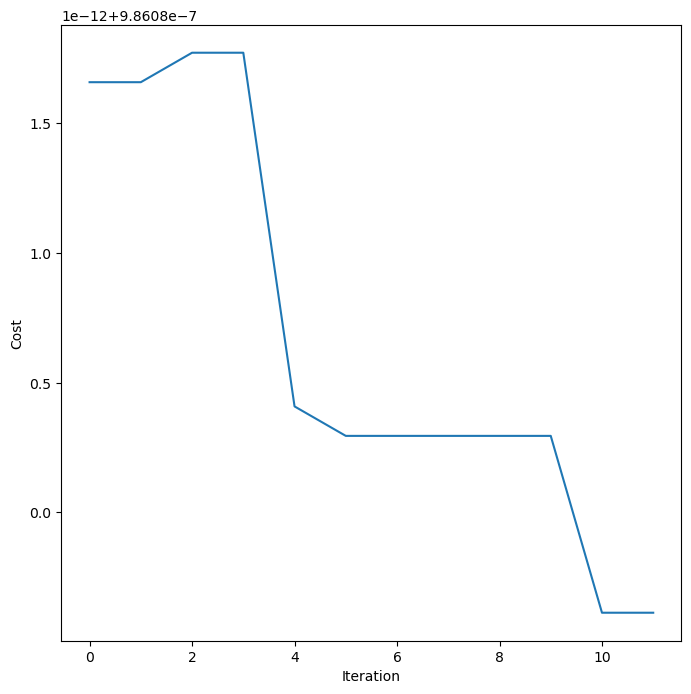

After optimization:  0.5145266652107239 4.697838118516984e-09 7.1730514


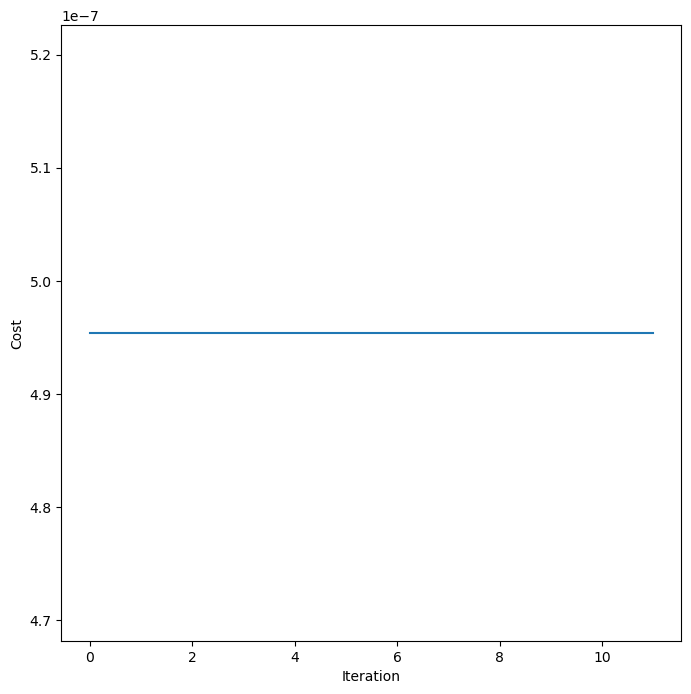

After optimization:  0.5145266652107239 4.6978390066954034e-09 7.1730514
Before optimization:  0.5145266652107239 4.70009942077354e-09 7.1730514


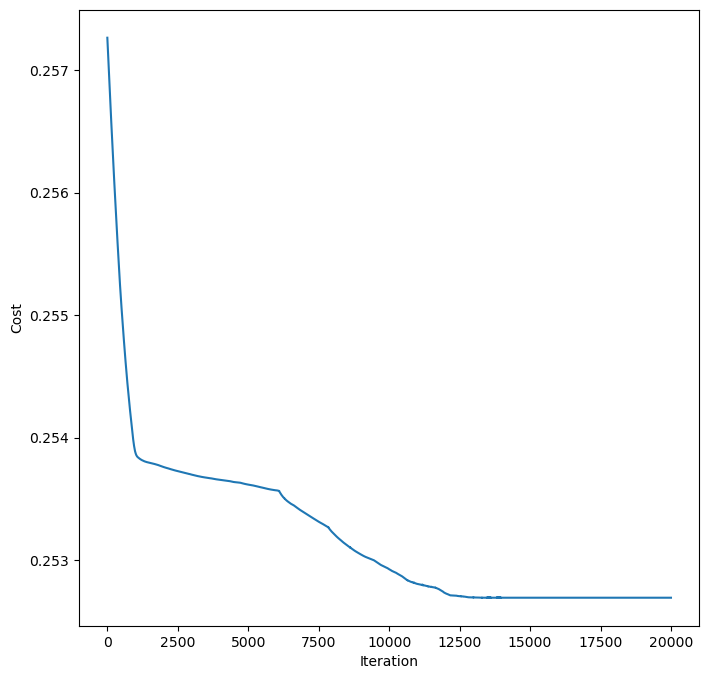

After optimization:  0.5029364824295044 0.0024517555721104145 7.074495


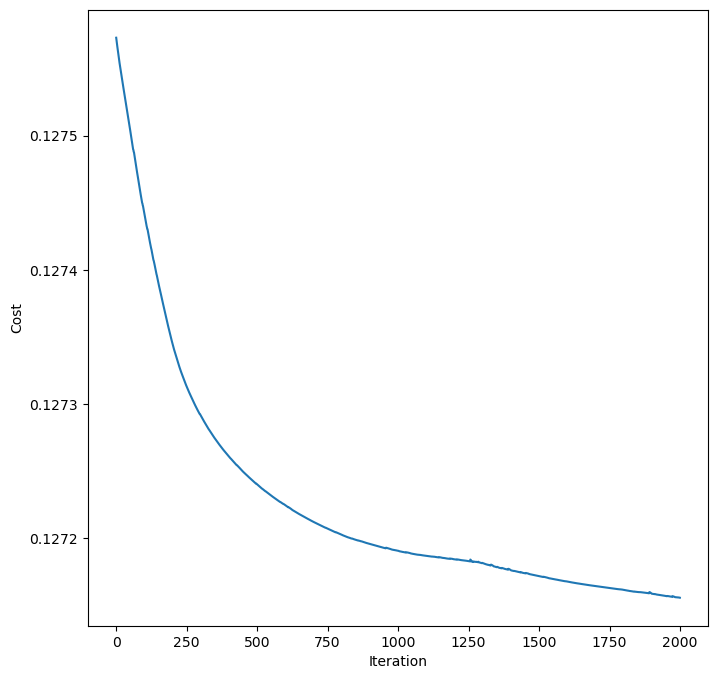

After optimization:  0.5056778788566589 0.0009816527599468827 7.104198


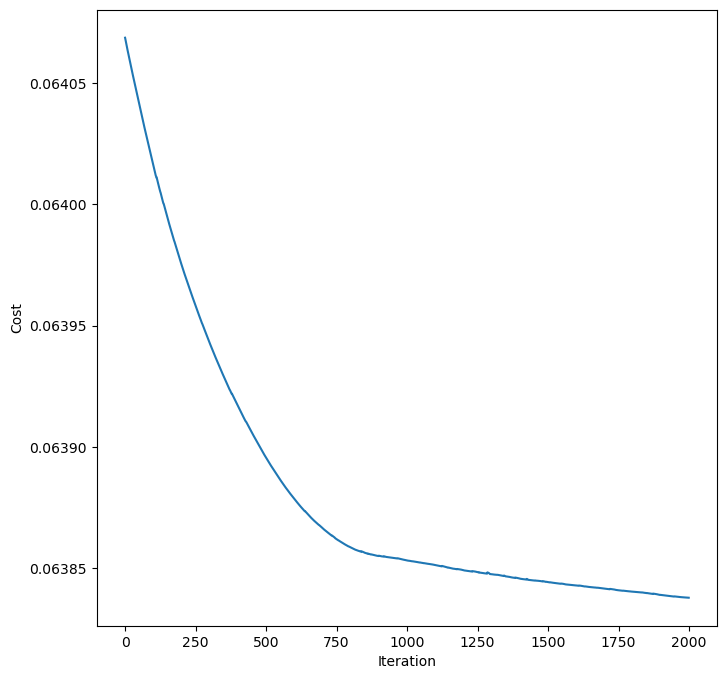

After optimization:  0.5087710618972778 0.0002759650524239987 7.130884


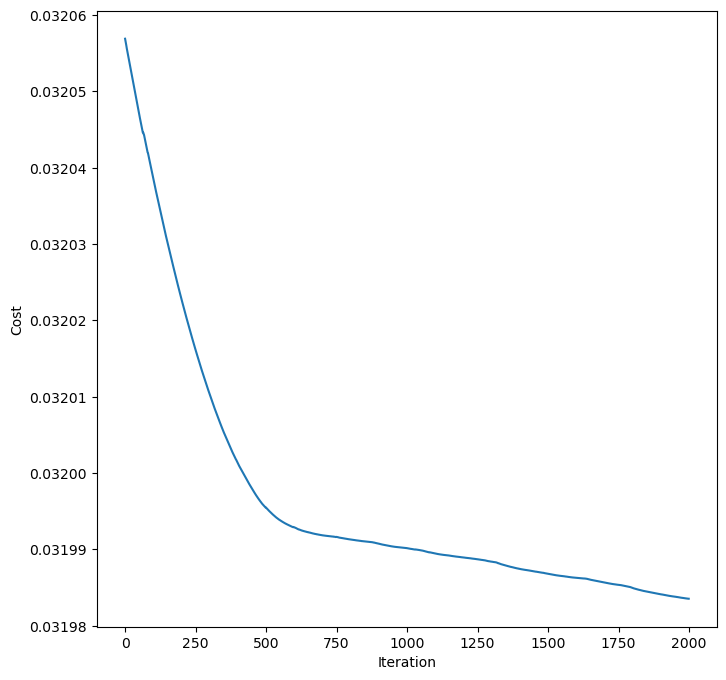

After optimization:  0.5107292532920837 6.714806659147143e-05 7.1460624


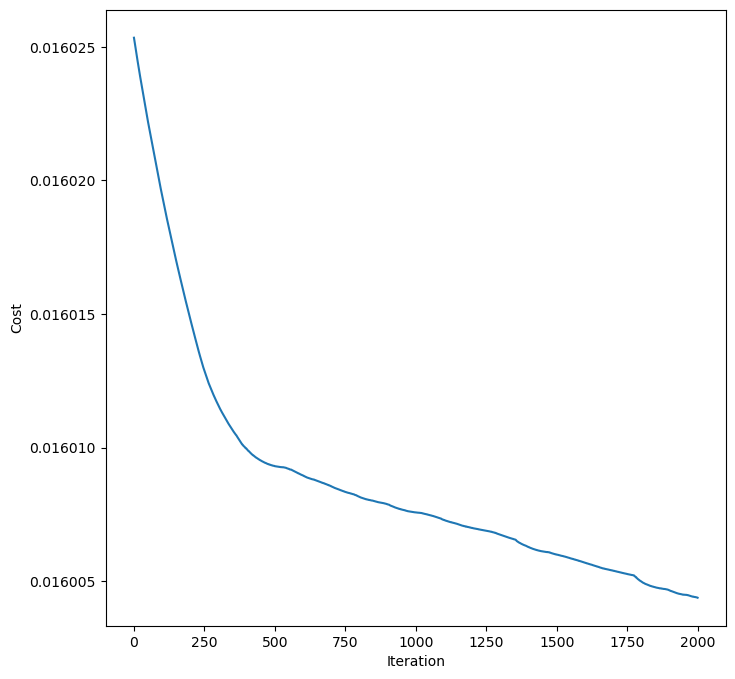

After optimization:  0.5116387605667114 1.617262023501098e-05 7.15278


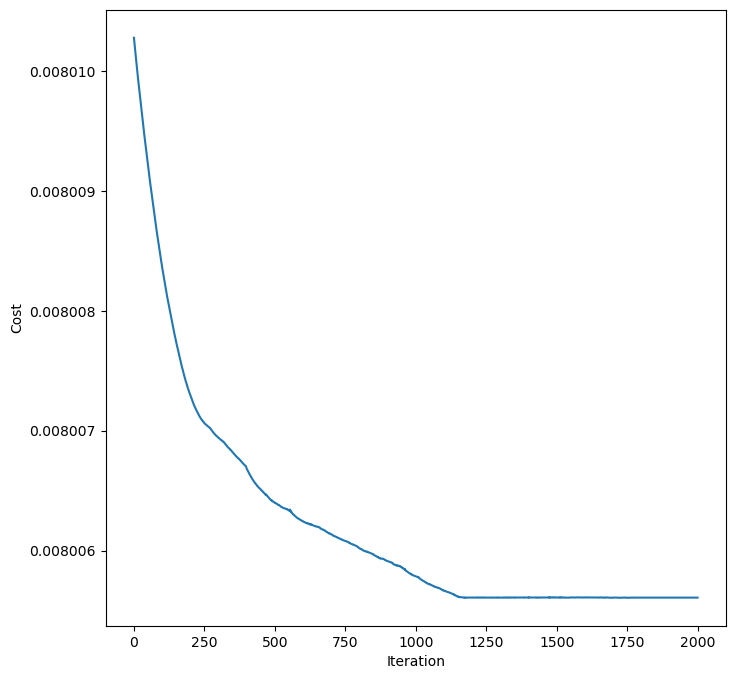

After optimization:  0.5120840072631836 4.364343567431206e-06 7.1559744


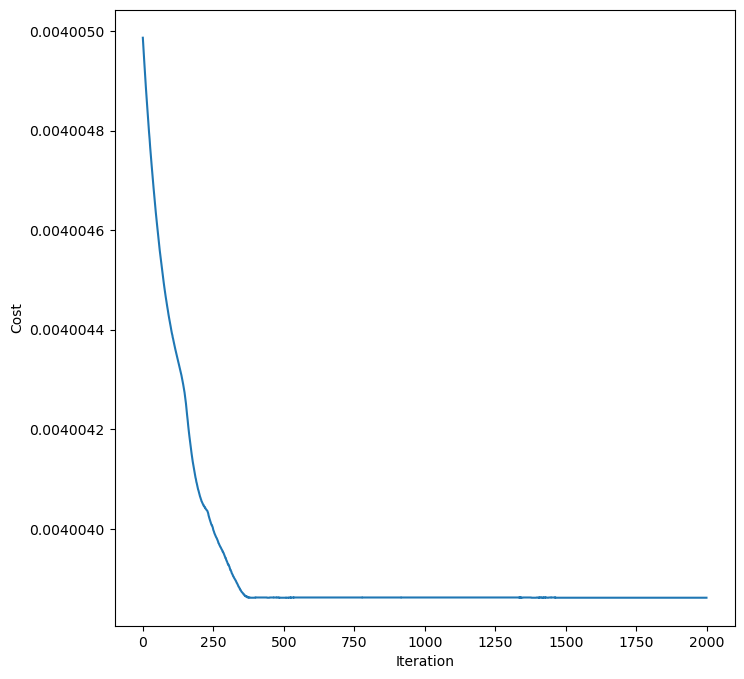

After optimization:  0.5123539566993713 1.1046824965887936e-06 7.157883


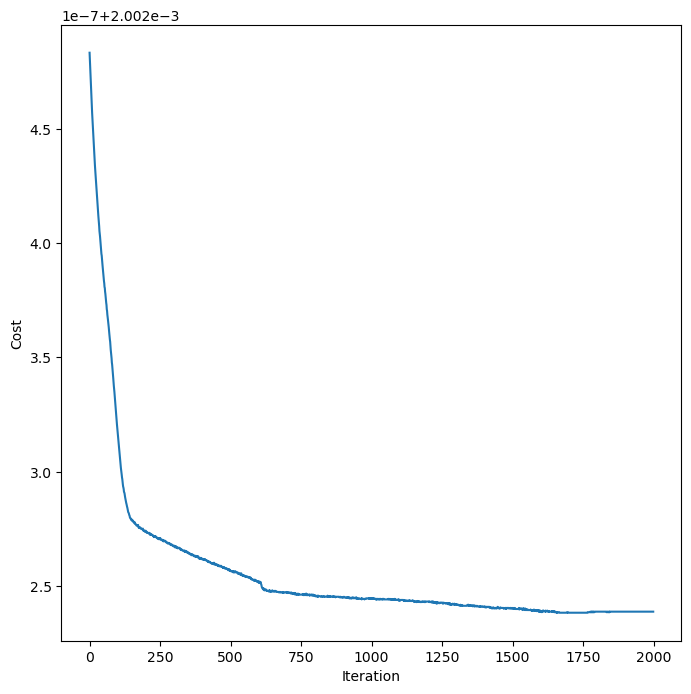

After optimization:  0.5124858021736145 3.4219701205984165e-07 7.158809


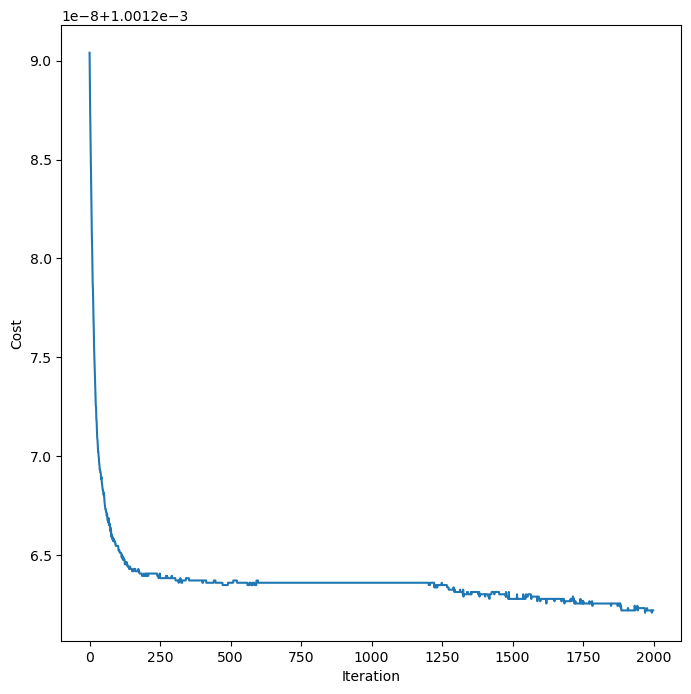

After optimization:  0.51251220703125 2.622969361709693e-07 7.158994


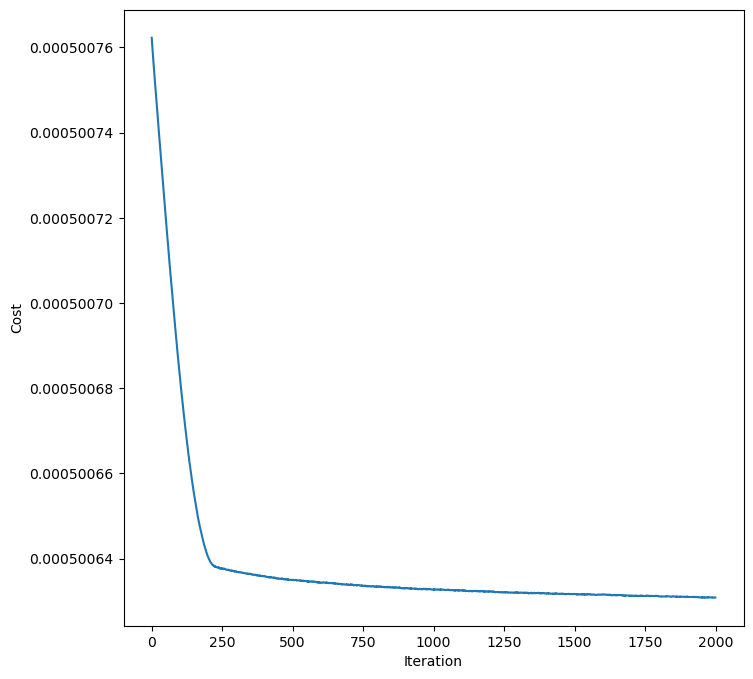

After optimization:  0.5126165151596069 2.8790044126481007e-08 7.159724


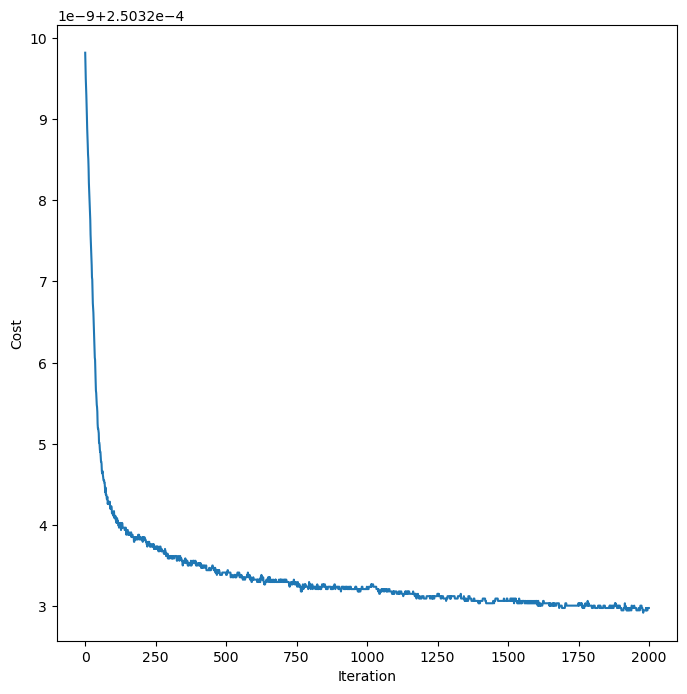

After optimization:  0.5126405358314514 1.0179971532409127e-08 7.159892


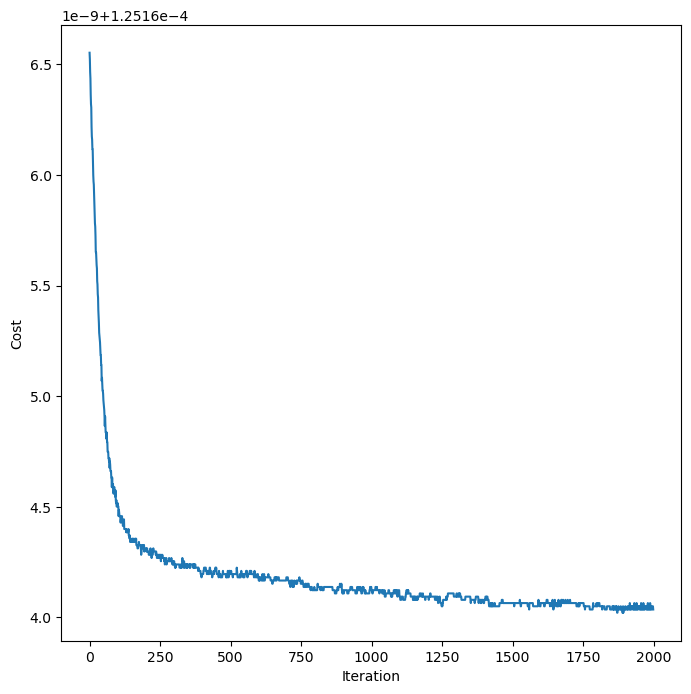

After optimization:  0.5126583576202393 3.315837826534107e-09 7.1600165


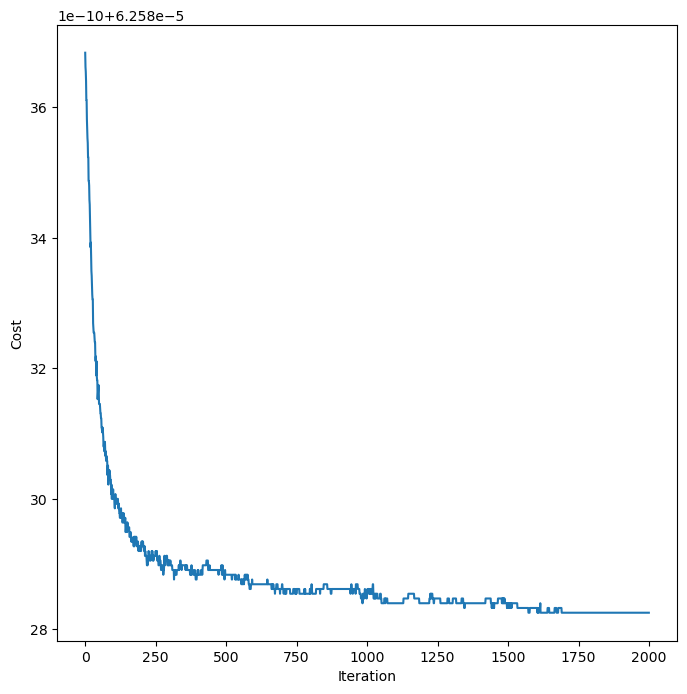

After optimization:  0.5126680731773376 1.2733956111787847e-09 7.1600842


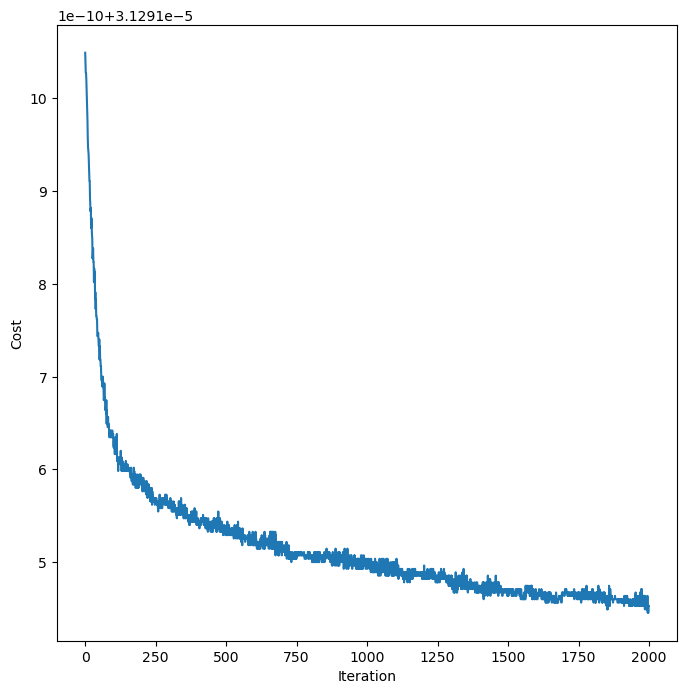

After optimization:  0.512675940990448 1.963208484667689e-10 7.1601396


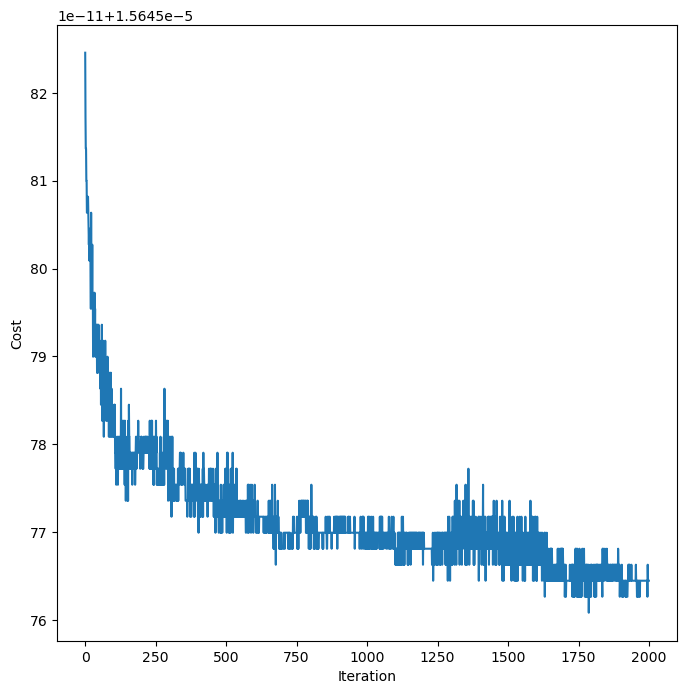

After optimization:  0.5126785039901733 5.742284078791293e-11 7.160157


SolutionCollectionSquare(comment='', xyt=array([[[-3.4502232 , -3.1794498 ,  0.3545576 ],
        [-3.4224663 , -1.9257448 ,  0.52588665],
        [-3.3221605 , -2.6339197 , -2.9099698 ],
        [-3.4019225 , -0.7117562 ,  0.38292992],
        [-3.3077104 , -1.3659506 , -2.7753973 ],
        [-3.3929684 ,  0.43707848,  0.4187474 ],
        [-3.282187  , -0.21768335, -2.7586627 ],
        [-3.4050114 ,  1.5771588 ,  0.4847773 ],
        [-3.2616365 ,  0.92384565, -2.7228453 ],
        [-3.4420915 ,  2.6995192 ,  0.48379645],
        [-3.276528  ,  2.0623684 , -2.6568158 ],
        [-3.2495856 ,  3.1391375 , -2.6578982 ],
        [-2.8931768 , -3.1692405 ,  0.35691556],
        [-2.8804011 , -1.8819565 ,  0.34737372],
        [-2.7783144 , -2.647101  , -2.7143784 ],
        [-2.8495286 , -0.7223328 ,  0.3489644 ],
        [-2.7698405 , -1.3775864 , -2.7869945 ],
        [-2.8184521 ,  0.43359095,  0.35174507],
        [-2.7395277 , -0.22027704, -2.7926283 ],
        [-2.8070285 ,  1.597

In [25]:
importlib.reload(pack_io)
import lbfgs_torch_parallel
importlib.reload(lbfgs_torch_parallel)
import pack_dynamics
importlib.reload(pack_dynamics)
pack_io.legalize(overall_best[147], move_factor=10., tolerance_rel_change=1e-7, do_plot=True, stop_on_cost_increase=False)

In [ ]:
overall_best_legalized = kgs.dill_load(kgs.code_dir + '../res/tess_legalized.pickle') 
from tqdm import tqdm
import os, time
import multiprocess

multiprocess.set_start_method("spawn", force=True)

def init_worker(base_delay=10.0):
    # Each worker sleeps a different amount once
    # (pid-based hash to avoid all workers sleeping the same)
    import os
    import time
    pid = os.getpid()
    slot = pid%10
    time.sleep(base_delay * slot)

def do_one(sol):
    import pack_io
    import kaggle_support as kgs
    kgs.set_float32(True)
    import pack_cost
    if pack_cost.CollisionCostSeparation().compute_cost_allocate(sol)[0].get()<1e-10:
        return sol
    return pack_io.legalize(sol, move_factor=100., tolerance_rel_change=0., do_plot=False)

with multiprocess.Pool(processes=10, initializer=init_worker, initargs=(10.0,)) as pool:
    overall_best_legalized = list(
        tqdm(pool.imap(do_one, overall_best_legalized),
             total=len(overall_best_legalized), desc="Legalizing")
    )

#kgs.dill_save(kgs.code_dir + '../res/tess_legalized.pickle', overall_best_legalized) 

Legalizing:   0%|          | 0/200 [00:00<?, ?it/s]0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It se

local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

Legalizing:  44%|████▎     | 87/200 [00:09<00:08, 12.64it/s]

ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
    240 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 43 registers, 240 bytes cumulative stack size, 404 bytes cmem[0], 32 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_overlap_list_total' for 'sm_89'
ptxas info    : Function properties for multi_overlap_list_total
    144 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 58 registers, 144 bytes cumulative stack size, 420 bytes cmem[0], 32 bytes cmem[2]


--- Kern

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin


Legalizing:  44%|████▎     | 87/200 [00:26<00:08, 12.64it/s]

ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
    240 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 43 registers, 240 bytes cumulative stack size, 404 bytes cmem[0], 32 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_overlap_list_total' for 'sm_89'
ptxas info    : Function properties for multi_overlap_list_total
    1264 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 78 registers, 1264 bytes cumulative stack size, 420 bytes cmem[0], 24 bytes cmem[2]


--- Ke

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.36664071679115295 0.0014007063582539558 6.043509
After optimization:  0.3675598204135895 0.0011992664076387882 6.0527725
After optimization:  0.3436262905597687 0.0005696966545656323 5.8571033
After optimization:  0.35928112268447876 0.0018527880311012268 5.978531
After optimization:  0.3535507619380951 0.0006467111525125802 5.9405727
After optimization:  0.36341333389282227 0.0018419473199173808 6.0130806
After optimization:  0.3436436653137207 0.0005661558825522661 5.8572817
After optimization:  0.3536217212677002 0.0006279483204707503 5.941328
After optimization:  0.35364794731140137 0.0006177261238917708 5.9416347
After optimization:  0.4256405532360077 0.0008118835976347327 6.517888
After optimization:  0.3683250844478607 0.0004000686458311975 6.0656824
After optimization:  0.3690452575683594 0.0003172500291839242 6.0722976
After optimization:  0.3613879978656769 0.0006743789417669177 6.0059443
After optimization:  0.36563318967819214 0.0005338009214028716 6

Legalizing:  50%|████▉     | 99/200 [2:18:20<3:12:06, 114.12s/it]

After optimization:  0.34557145833969116 4.729568126027317e-11 5.878533
Before optimization:  0.47567421197891235 1.2925344128333904e-10 6.896914


Legalizing:  50%|█████     | 100/200 [2:19:41<3:09:07, 113.48s/it]

After optimization:  0.34557145833969116 3.385727809224193e-11 5.878533
Before optimization:  0.47631317377090454 1.6103043898318958e-10 6.9015446
After optimization:  0.4283457100391388 6.635587218584149e-11 6.5448127
Before optimization:  0.49292421340942383 2.706274926378427e-10 7.0208564


Legalizing:  52%|█████▏    | 103/200 [2:21:27<2:53:49, 107.52s/it]

After optimization:  0.3573780655860901 2.7851332351502833e-11 5.978111
Before optimization:  0.4929220974445343 2.1383146642239836e-10 7.020841


Legalizing:  52%|█████▏    | 104/200 [2:23:46<2:53:47, 108.62s/it]

After optimization:  0.3573821187019348 2.33640745639363e-11 5.9781446
Before optimization:  0.492926687002182 3.3685915168391034e-10 7.020874
After optimization:  0.4494102895259857 0.00019030676048714668 6.7023873
After optimization:  0.4494229555130005 0.00018805560830514878 6.702499
After optimization:  0.4701941907405853 0.0008948111208155751 6.8505435
After optimization:  0.4682098627090454 0.0008964721346274018 6.8360324
After optimization:  0.47133854031562805 0.0008953467477113008 6.8588862
After optimization:  0.4731048345565796 0.0008033490739762783 6.8724194
After optimization:  0.45001474022865295 5.1260896725580096e-05 6.707932
After optimization:  0.4739246964454651 0.0007536992197856307 6.8787427
After optimization:  0.4500214159488678 5.07483709952794e-05 6.7079854
After optimization:  0.47125399112701416 0.00022536037431564182 6.8631525
After optimization:  0.4901580810546875 0.0007769446820020676 6.9955783
After optimization:  0.4901581108570099 0.0007768283248879015

In [ ]:
kgs.dill_save(kgs.code_dir + '../res/tess_legalized.pickle', overall_best_legalized) 